In [1]:
import numpy as np
import astropy as ast
import matplotlib.pyplot as plt

from astropy import units as u

In [2]:
def get_phi(vector: np.ndarray) -> float:
    """Return the azimuthal angle of vector (in conventional spherical coordinates).
    """
    
    if vector[0] > 0:
        return np.arctan(vector[1] / vector[0])
    elif vector[0] < 0 :
        return np.arctan(vector[1] / vector[0]) + np.pi
    else:
        if vector[1] > 0:
            return np.pi / 2
        elif vector[1] < 0:
            return -np.pi / 2
        else:
            return 0

In [3]:
def get_theta(vector: np.ndarray) -> float:
    """Return the polar angle of vector (in conventional spherical coordinates).
    """
    
    rho = np.sqrt(np.sum(vector ** 2))
    
    if rho != 0:
        return np.arccos(vector[2] / rho)
    else:
        return np.pi / 2

In [4]:
def build_triple_rotation_matrix(ref_r: np.ndarray, ref_L: np.ndarray) -> np.ndarray:
    """Return a matrix object to transform vectors to from an original coordinate system
    to a coordinate system where (x = ref_r, y = 0, z = 0) and z points along ref_L.
    """
    
    # get the angles of spherical coordinates of ref_r
    phi = get_phi(ref_r)
    theta = get_theta(ref_r)
    
    # rotation 1 rotates around z-axis 
    rotation_1 = np.zeros([3, 3])
    
    rotation_1[0][0] = np.cos(phi)
    rotation_1[0][1] = np.sin(phi)
    rotation_1[1][0] = -np.sin(phi)
    rotation_1[1][1] = np.cos(phi)
    rotation_1[2][2] = 1
    
    # rotation 2 rotates around new y-axis
    rotation_2 = np.zeros([3, 3])
    
    rotation_2[0][0] = np.sin(theta)
    rotation_2[0][2] = np.cos(theta)
    rotation_2[2][0] = -np.cos(theta)
    rotation_2[2][2] = np.sin(theta)
    rotation_2[1][1] = 1
    
    double_rotation = rotation_2 @ rotation_1
    
    # rotate ref_L by rotation_1 then rotation_2
    interm_L = double_rotation @ ref_L
    
    # rearrange components of interm_L to get azimuthal angle w.r.t. x instead of z
    pseudo_L = np.array([
        interm_L[1],
        interm_L[2],
        interm_L[0]
    ])
    
    pseudo_phi = get_phi(pseudo_L)
    
    # rotation_3 rotates around new x-axis
    rotation_3 = np.zeros([3, 3])
    
    rotation_3[0][0] = 1
    rotation_3[1][1] = np.sin(pseudo_phi)
    rotation_3[1][2] = -np.cos(pseudo_phi)
    rotation_3[2][1] = np.cos(pseudo_phi)
    rotation_3[2][2] = np.sin(pseudo_phi)
    
    return rotation_3 @ double_rotation

In [5]:
# begin copied from previous notebook

In [19]:
dir = '/data/vxtest/514d'

filename =  dir+'/snapshot_1300'
haloname = dir+'/h1300.z0.000.AHF_halos'

In [21]:
dh = np.loadtxt(haloname)
xh = dh[:,5]
yh = dh[:,6]
zh = dh[:,7]
vxh = dh[:,8]
vyh = dh[:,9]
vzh = dh[:,10]

hd = np.fromfile(filename,dtype='int32',count=7)
nd = hd[2]
ns = hd[5]
nc = hd[3]
head = np.fromfile(filename,dtype='double',count=7,offset=4+6*4)
time=head[6]

start_d = 0
start_c = nd
start_s = nd + nc
block = nd + nc + ns

skipx = 256 + 3*4 + start_c*3*8
skipv = 256 + 5*4 + (block*3 + start_c*3)*8
skipi = 256 + 7*4 + block*3*2*8 + start_c*4
rc = np.fromfile(filename,dtype='double',count=3*nc,offset=skipx)
vc = np.fromfile(filename,dtype='double',count=3*nc,offset=skipv)

idc = np.fromfile(filename,dtype='uint32',count=nc,offset=skipi)
jxc = rc[0::3] - xh[0]
jyc = rc[1::3] - yh[0]
jzc = rc[2::3] - zh[0]

jvxc = vc[0::3] - vxh[0]
jvyc = vc[1::3] - vyh[0]
jvzc = vc[2::3] - vzh[0]

idc -= nd
ki = np.zeros(nc,dtype='int32')

for j in range(nc):
    ix = idc[j]
    ki[ix] = j

xc = jxc[ki]
yc = jyc[ki]
zc = jzc[ki]

vxc = jvxc[ki]
vyc = jvyc[ki]
vzc = jvzc[ki]

skipx = 256 + 3*4 + start_s*3*8
skipv = 256 + 5*4 + block*3*8 + start_s*3*8 #skip over r, and dm+c v's
skipi = 256 + 7*4 + block*3*2*8 + start_s*4 #skip over r and v and dm+c id
skipc = 256 + 9*4 + block*(2*3*8+4) + start_s*4 #skip over r, v and id and dm+c ic

rs = np.fromfile(filename,dtype='double',count=3*ns,offset=skipx)
vs = np.fromfile(filename,dtype='double',count=3*ns,offset=skipv)
ics = np.fromfile(filename,dtype='uint32',count=ns,offset=skipc)

xs = rs[0::3] - xh[0]
ys = rs[1::3] - yh[0]
zs = rs[2::3] - zh[0]
vxs = vs[0::3] - vxh[0]
vys = vs[1::3] - vyh[0]
vzs = vs[2::3] - vzh[0]

# distance from centre of galaxy
ds = np.sqrt(xs ** 2 + ys ** 2 + zs ** 2)

In [22]:
# end copied from previous notebook

In [23]:
zoom = 4
dg = 1/90

lon_max = np.pi / zoom
lat_max = np.pi / 2 / zoom

ng_lon = int(2 * lon_max / dg + 1) 
ng_lat = int(2 * lat_max / dg + 1)

lon = np.linspace(-lon_max, lon_max, ng_lon + 1) 
lat = np.linspace(-lat_max, lat_max, ng_lat + 1) 
lon_v, lat_v = np.meshgrid(lon, lat)

In [24]:
lon_range_deg = np.arange(-40, 50, 10)
lon_range_deg_str = []

for deg in lon_range_deg:
    s = str(deg) + r'$^{\circ}$'
    lon_range_deg_str.append(s)
    
    
lat_range_deg = np.arange(-20, 25, 5)
lat_range_deg_str = []

for deg in lat_range_deg:
    s = str(deg) + r'$^{\circ}$'
    lat_range_deg_str.append(s)

In [25]:
# Zoomed in

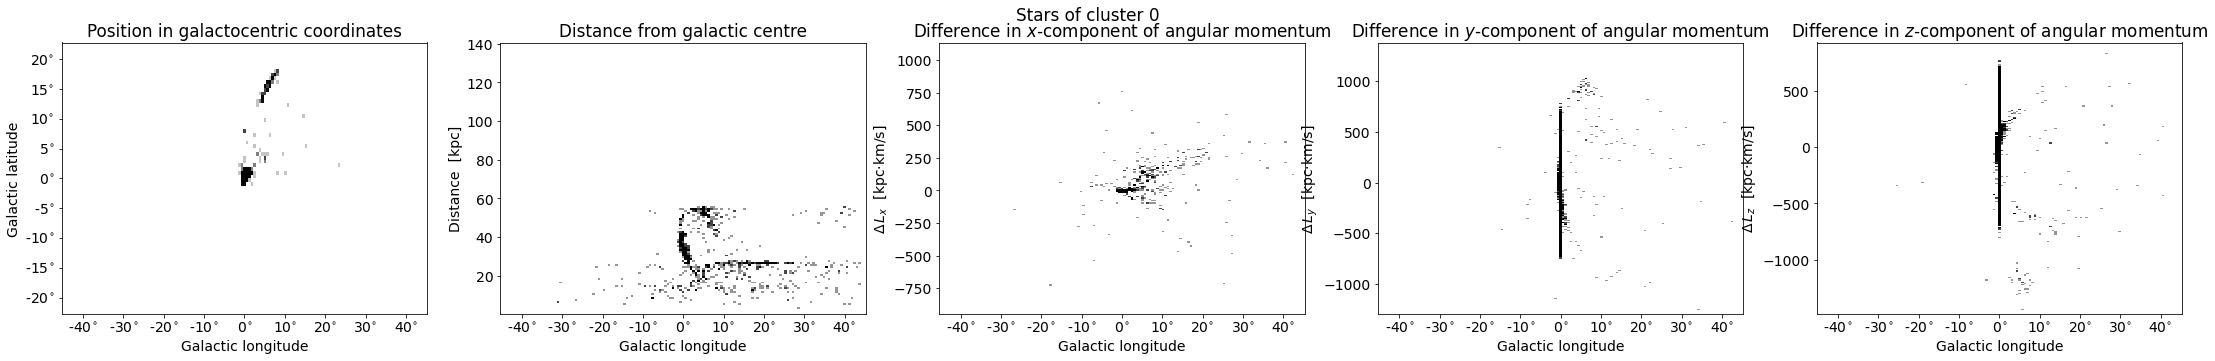

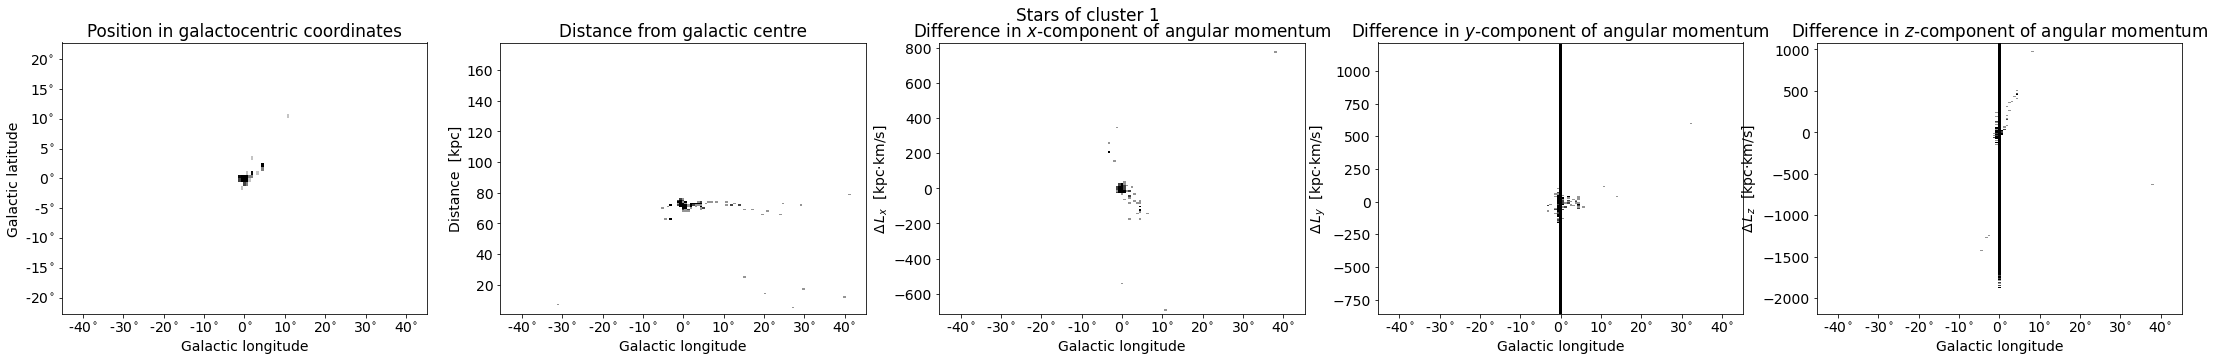

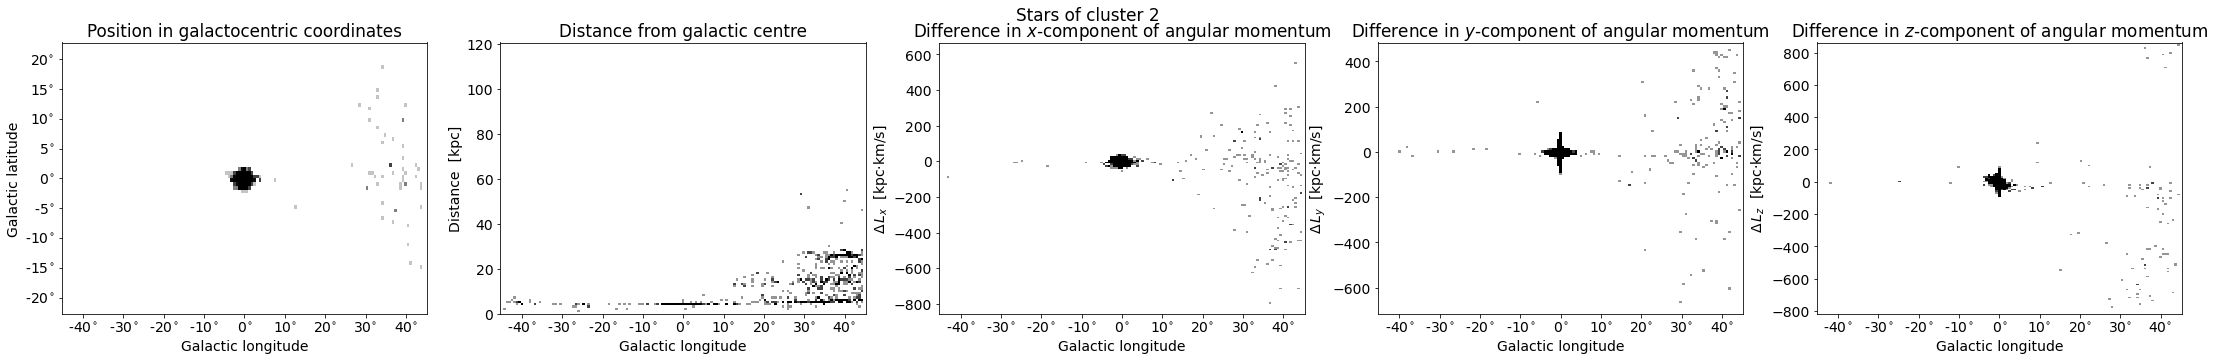

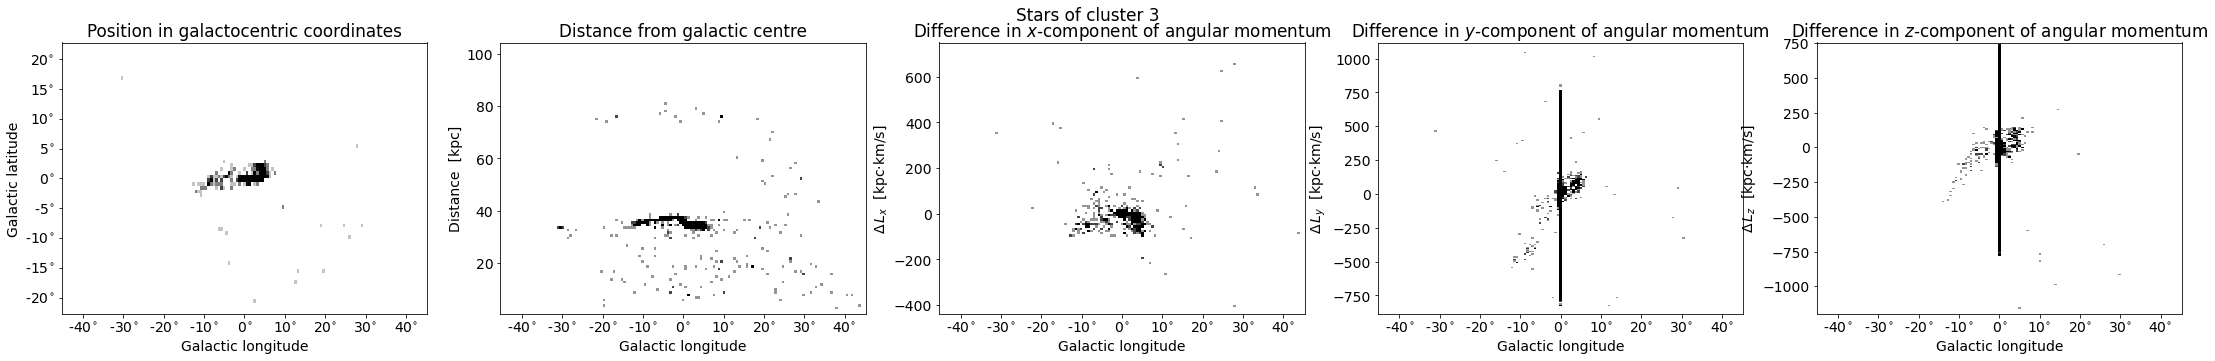

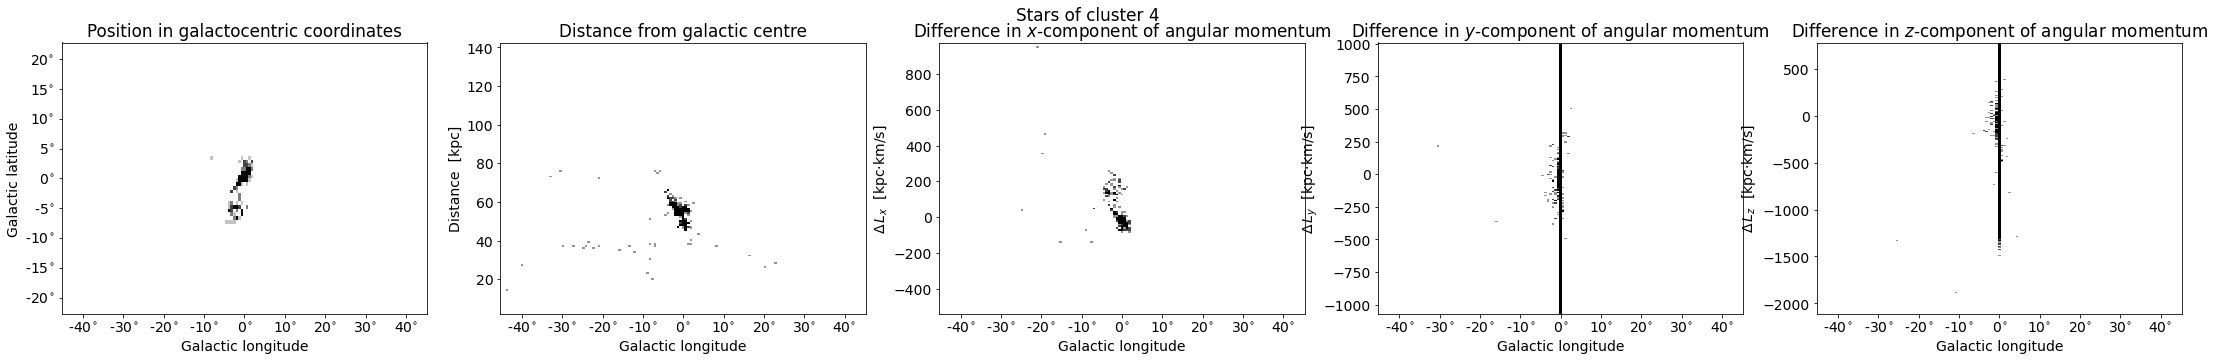

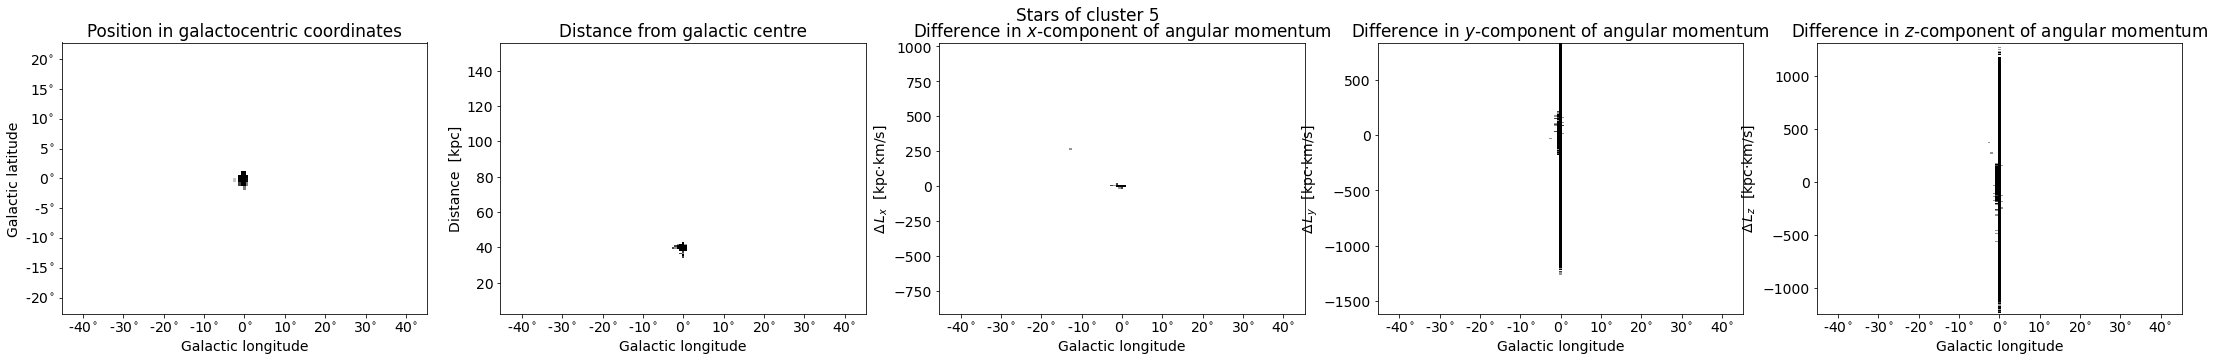

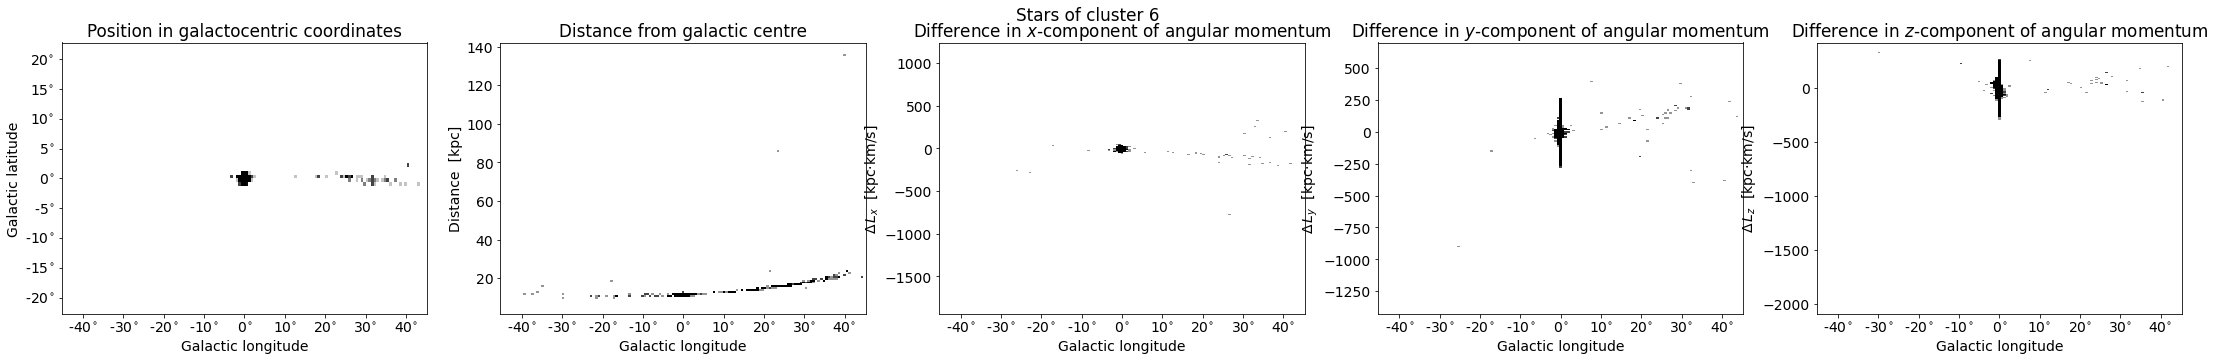

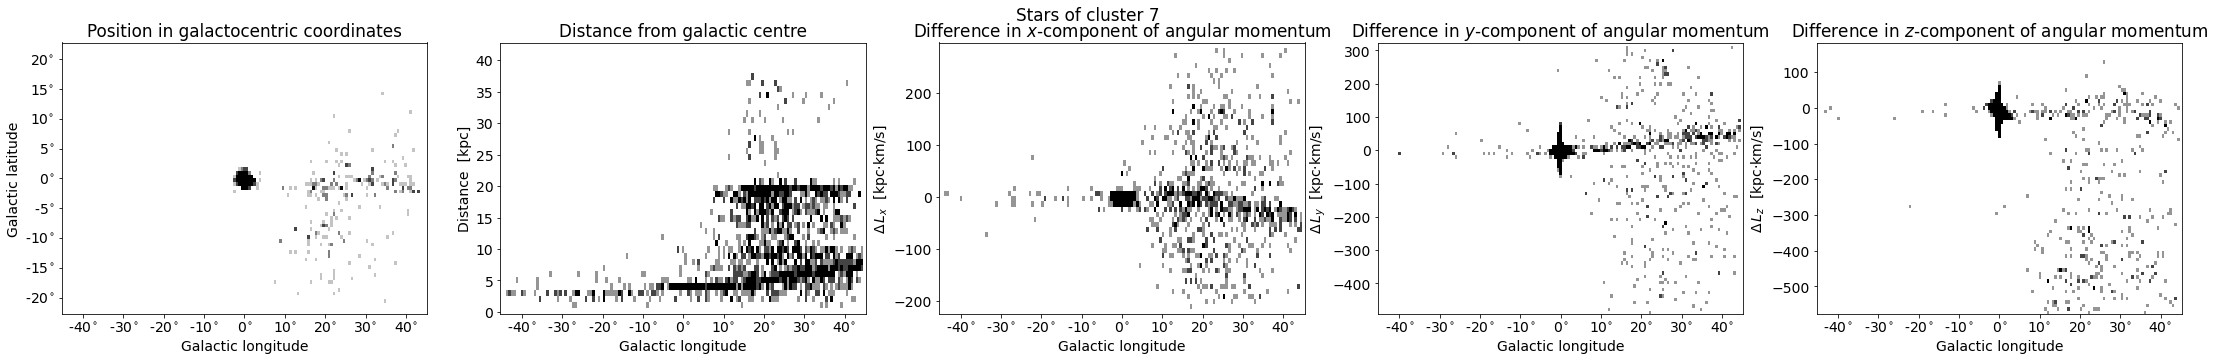

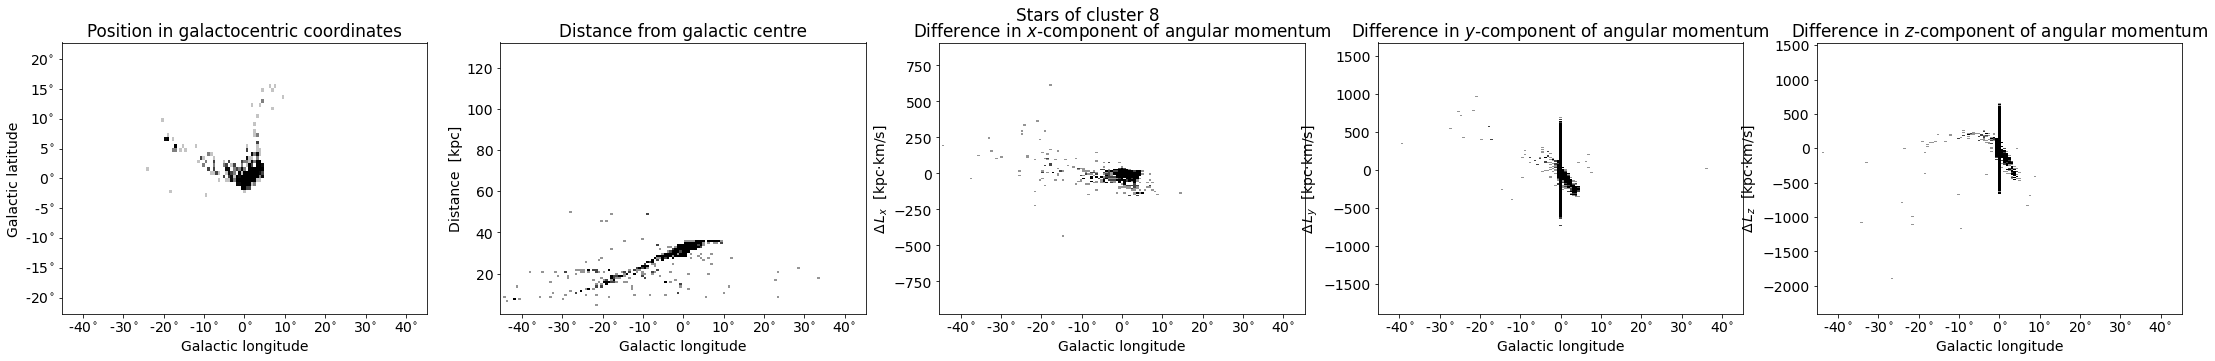

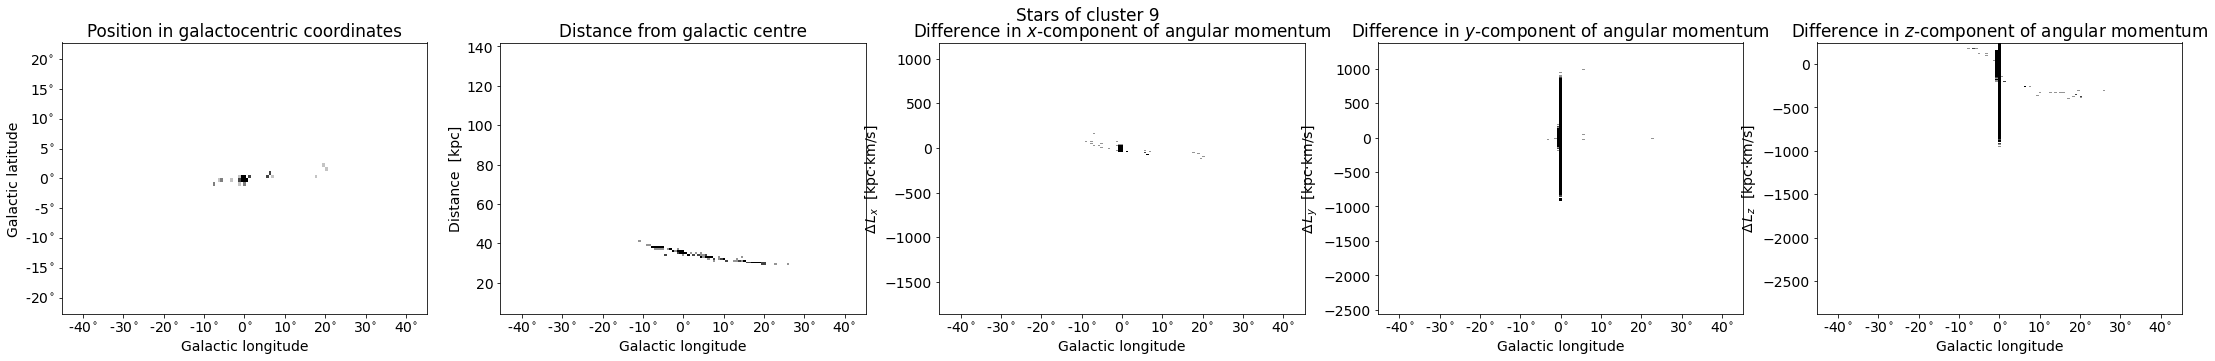

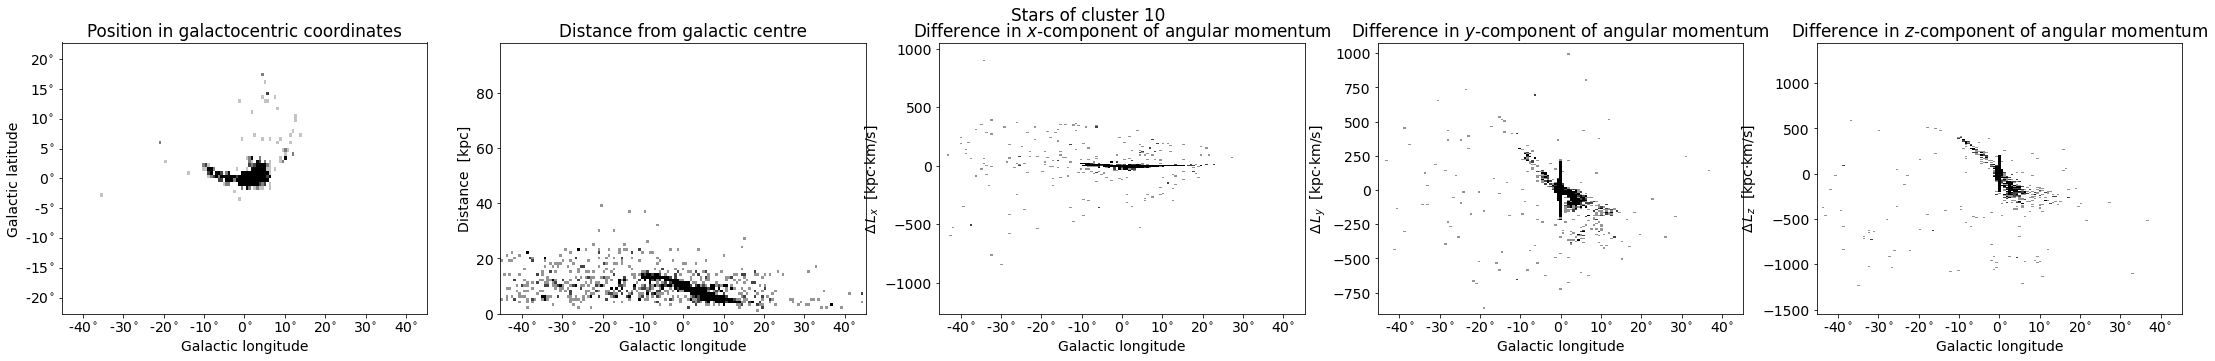

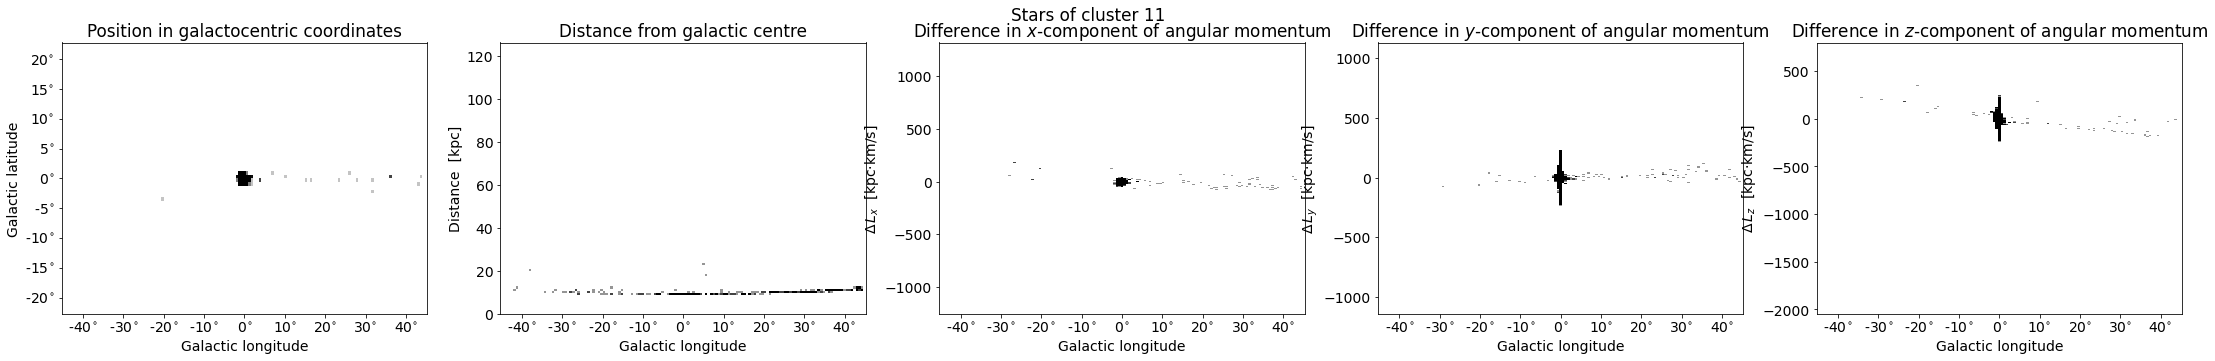

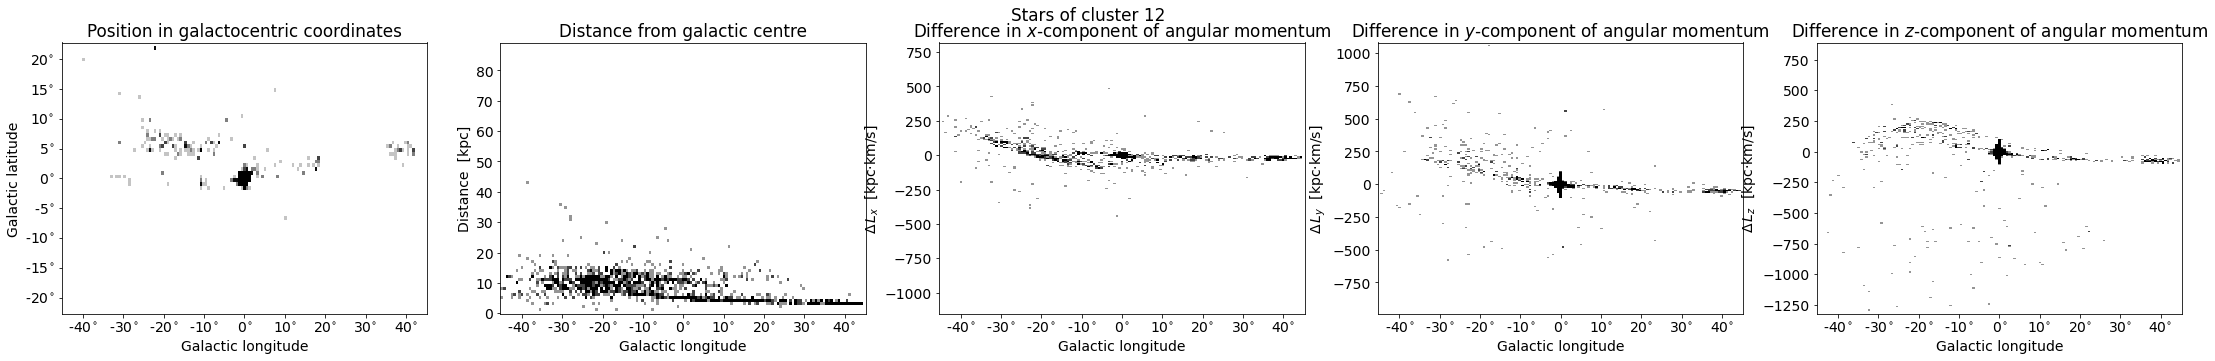

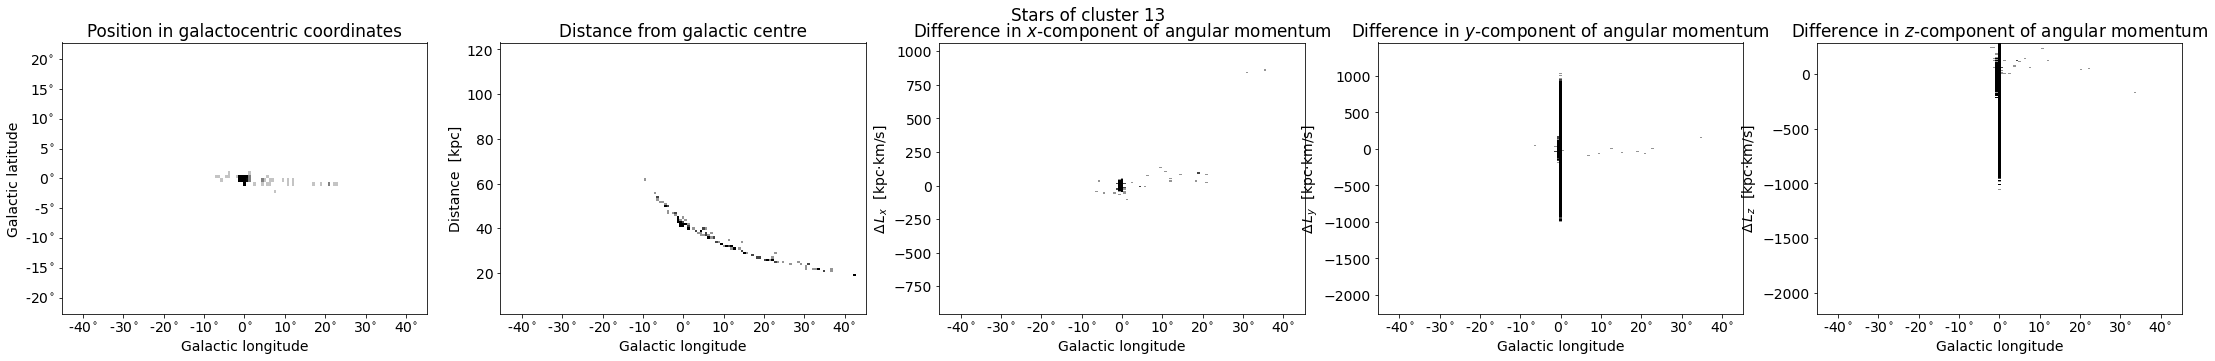

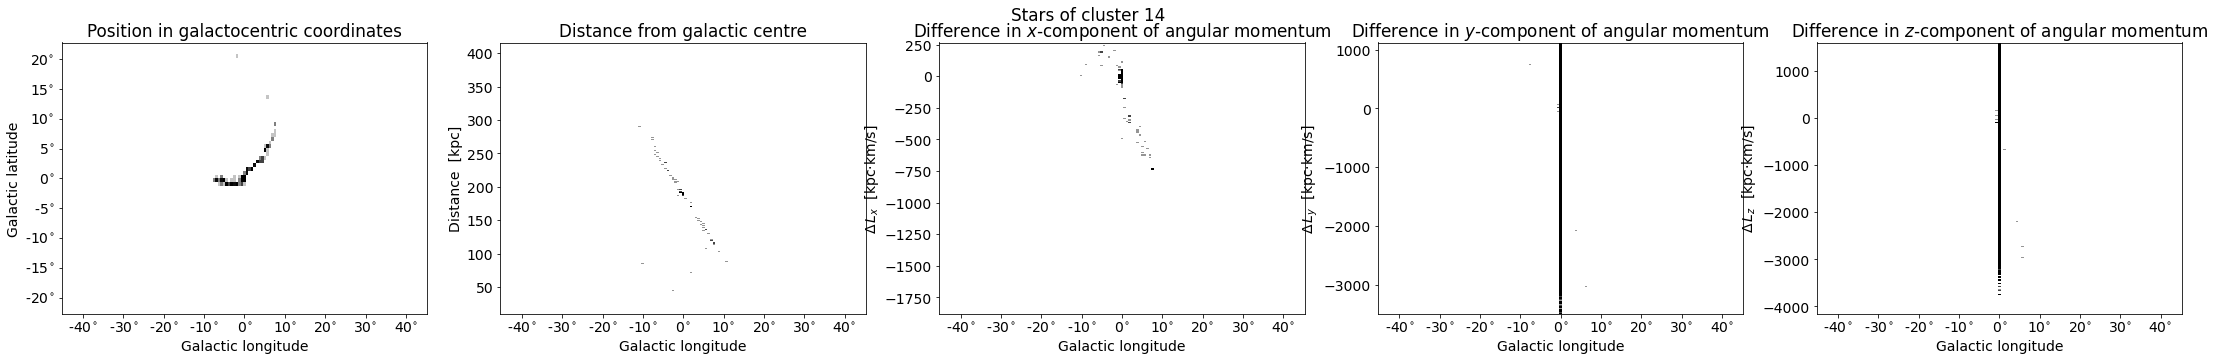

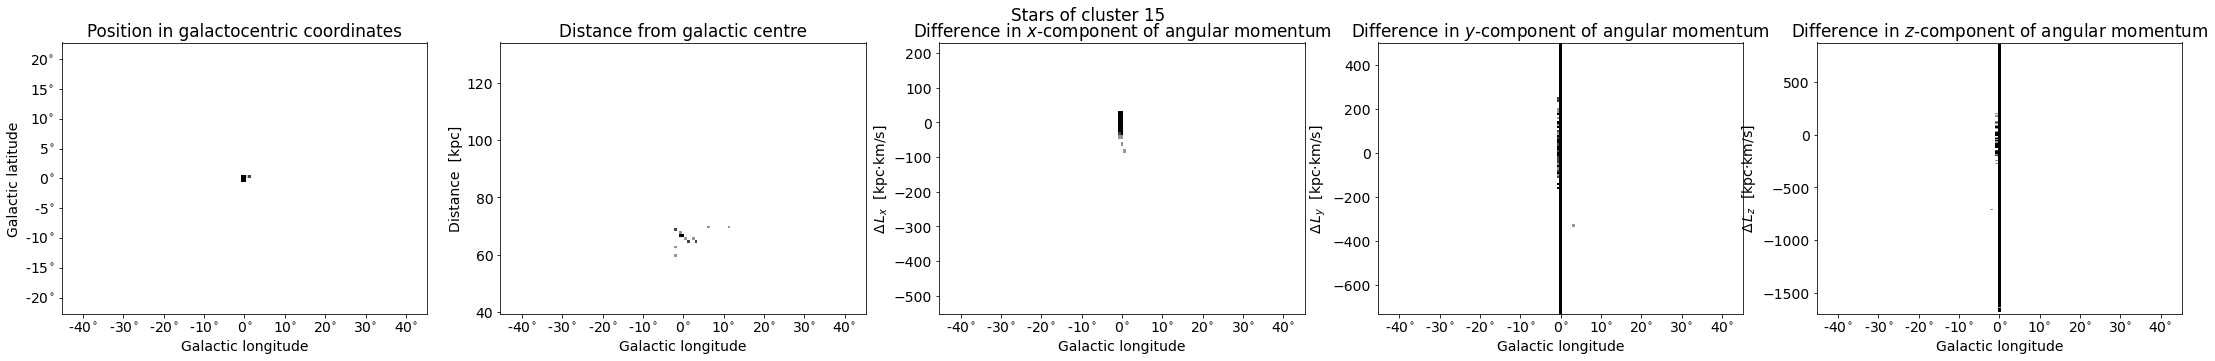

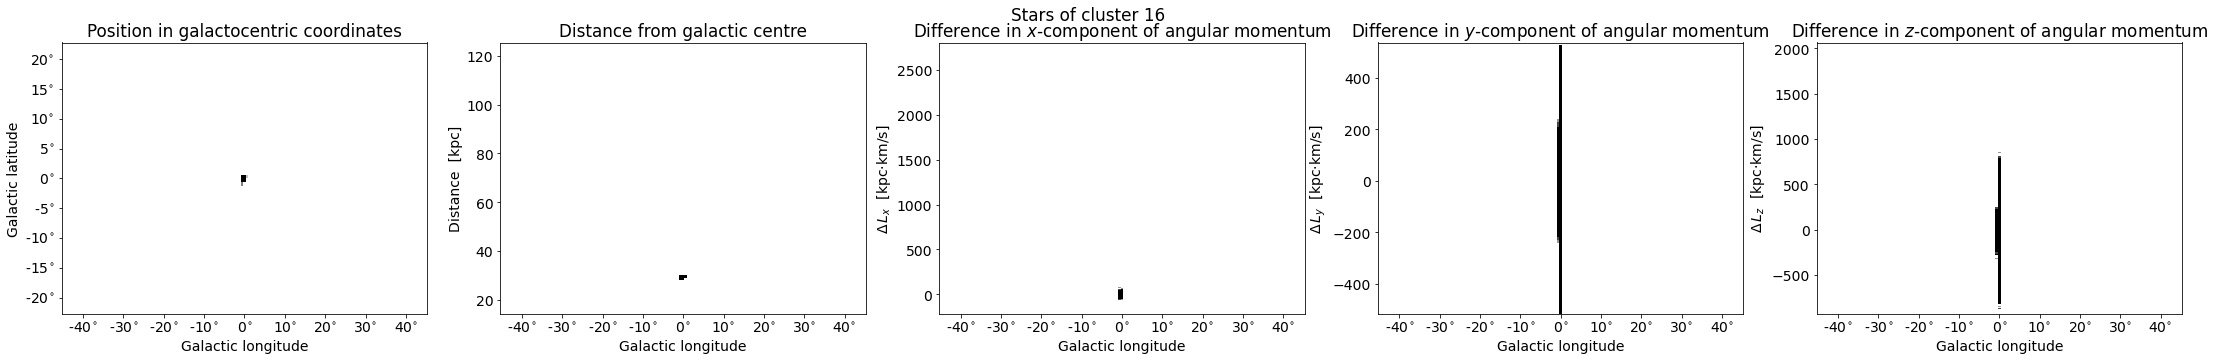

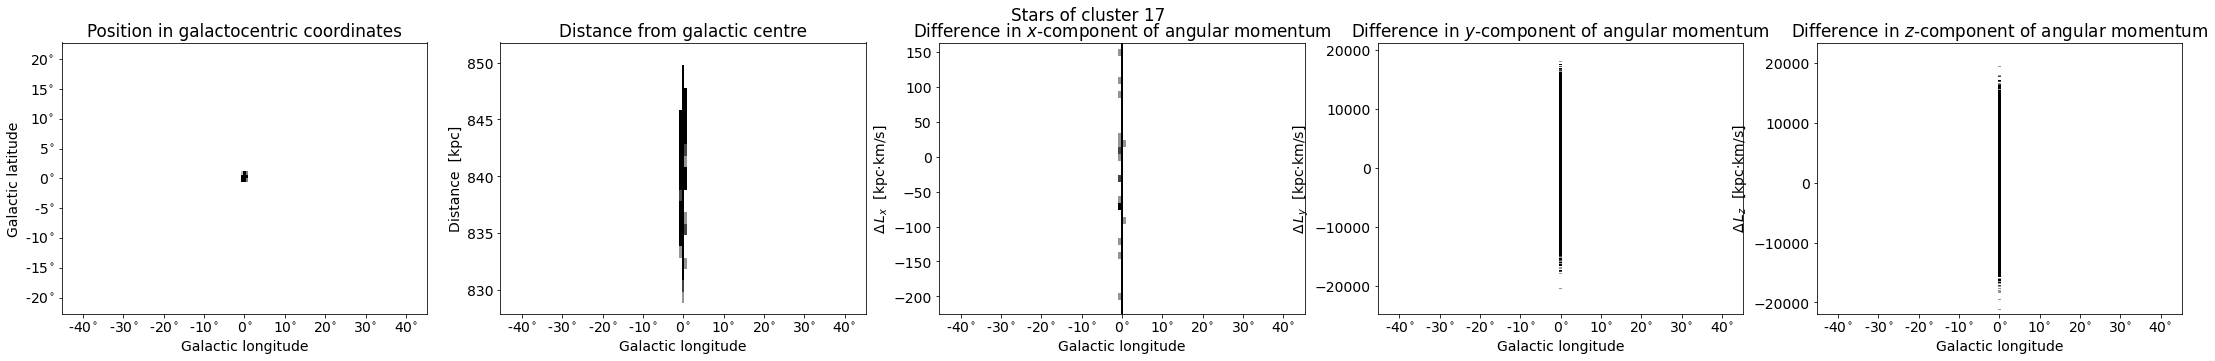

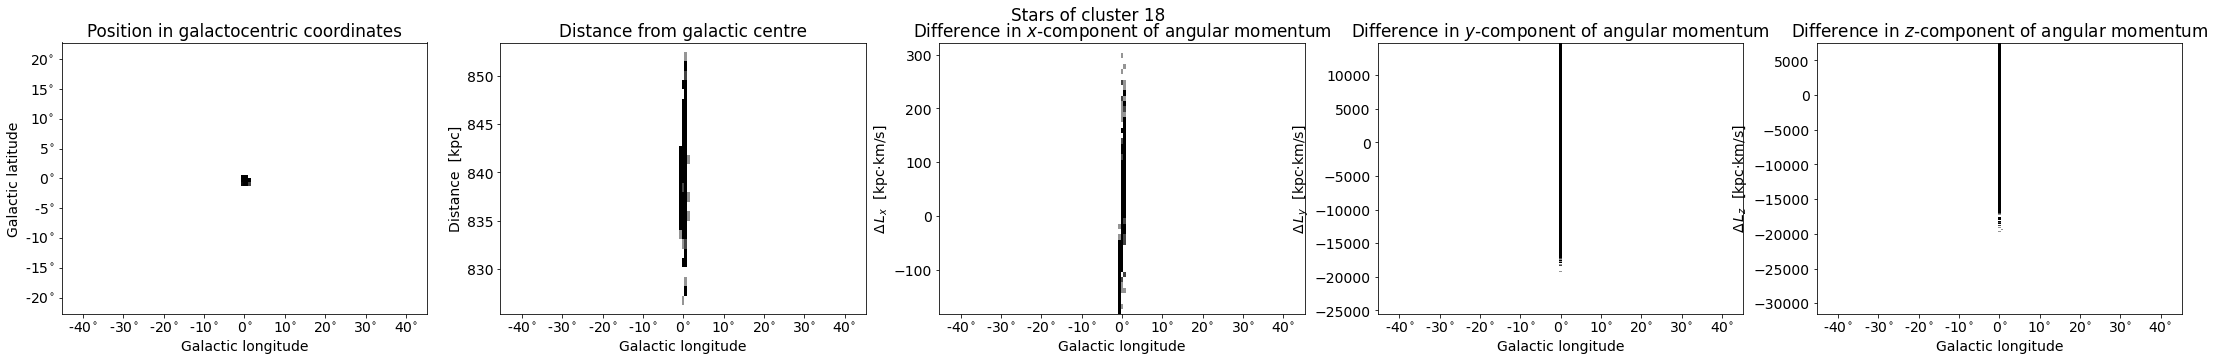

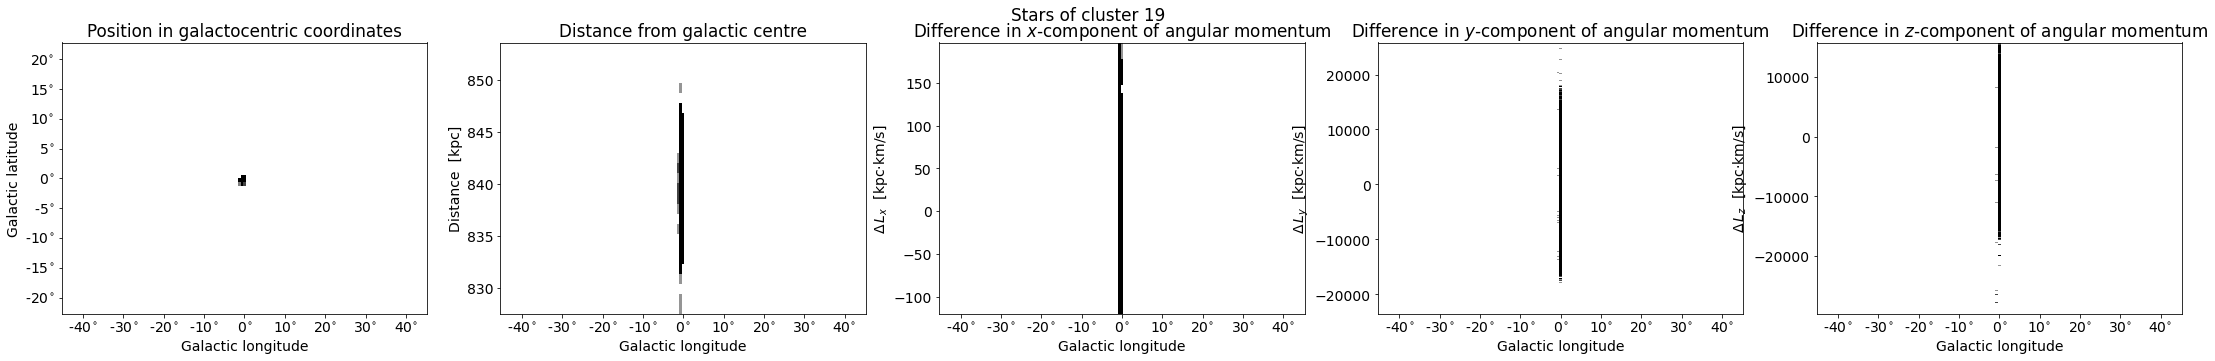

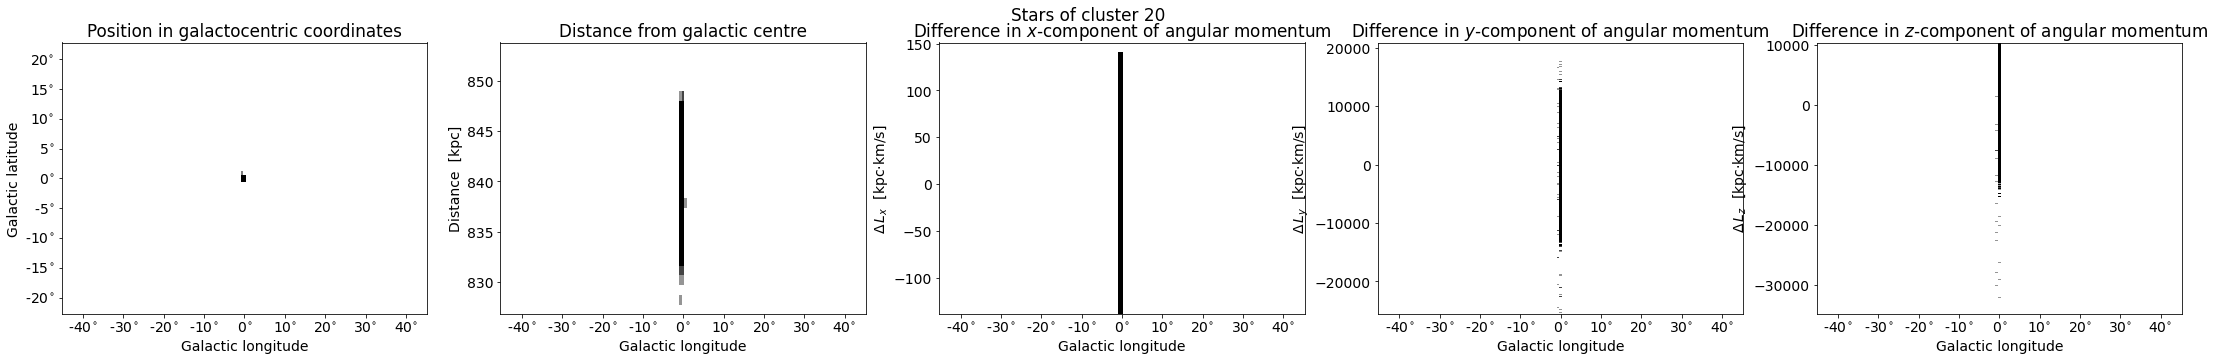

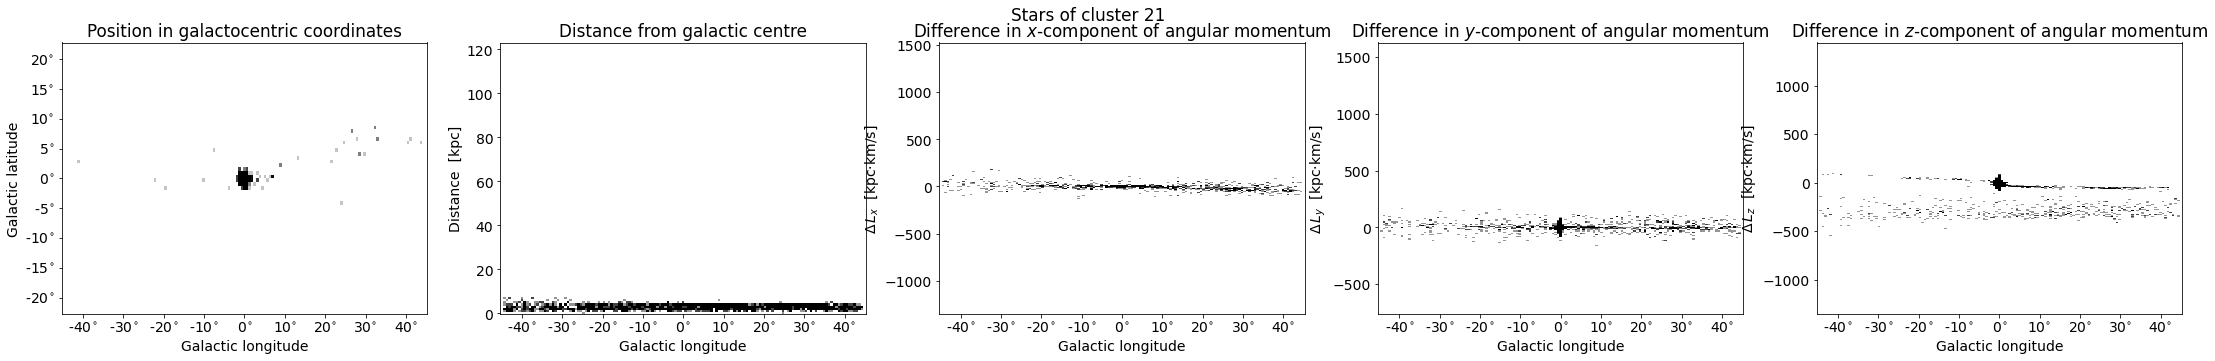

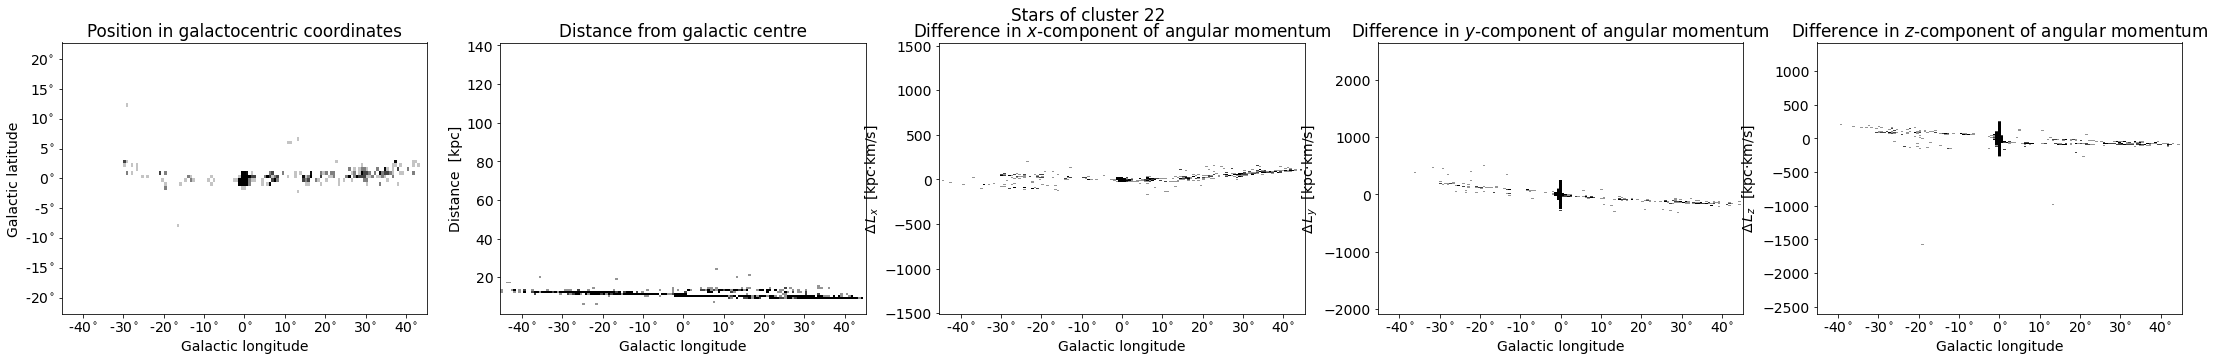

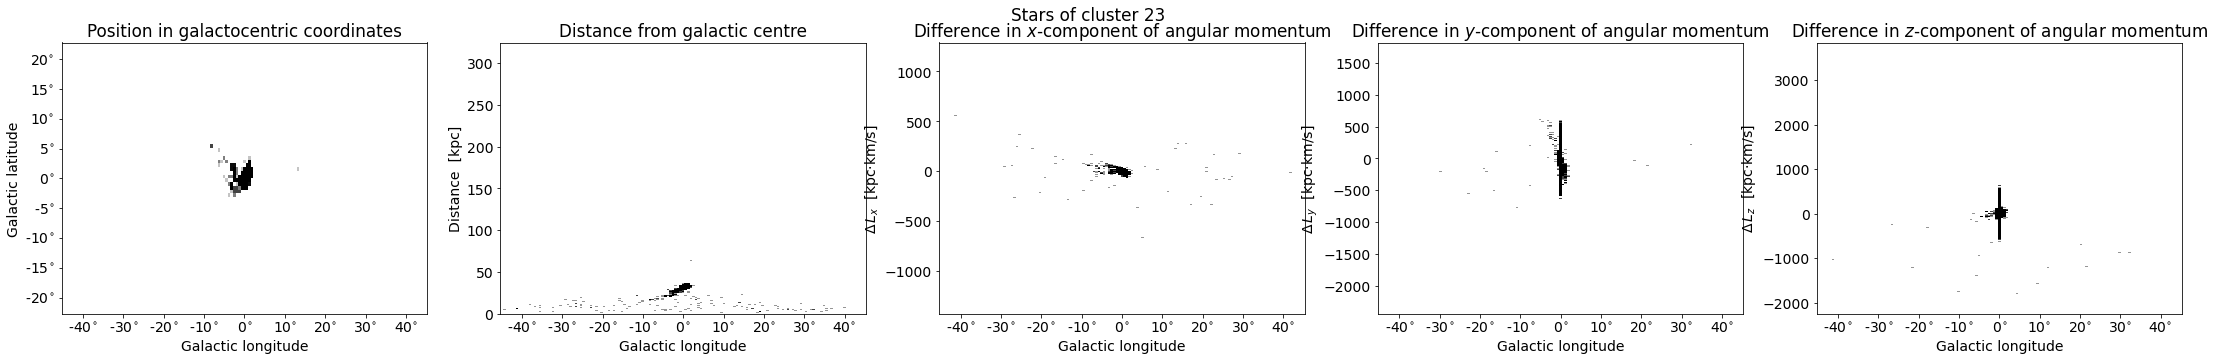

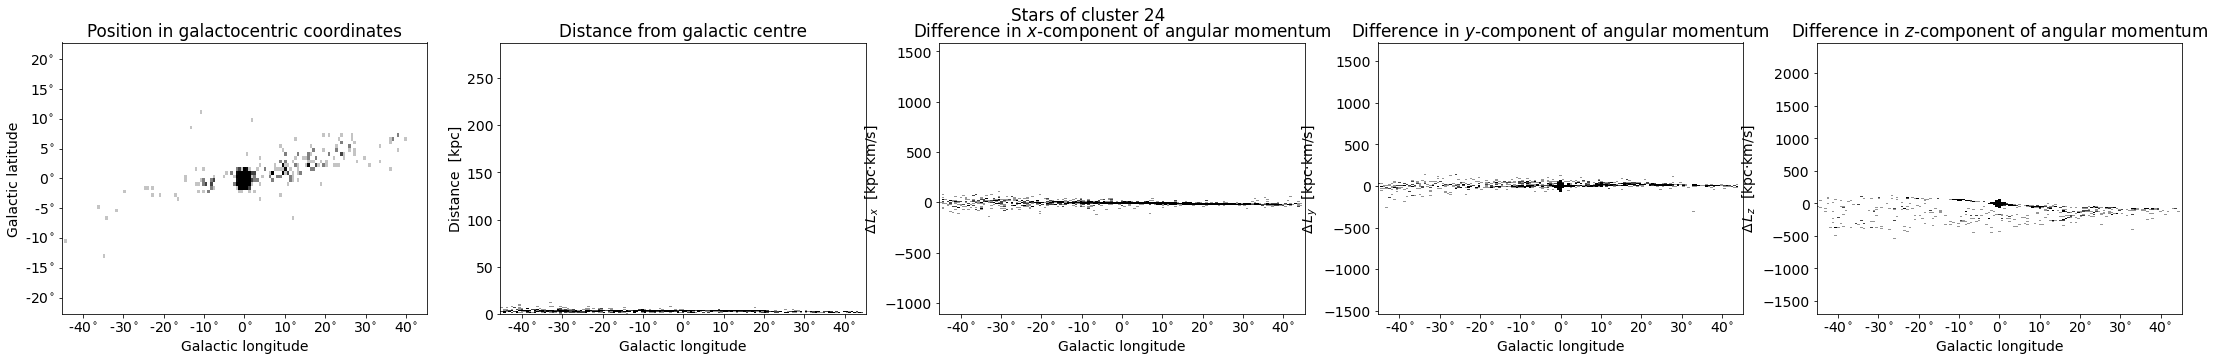

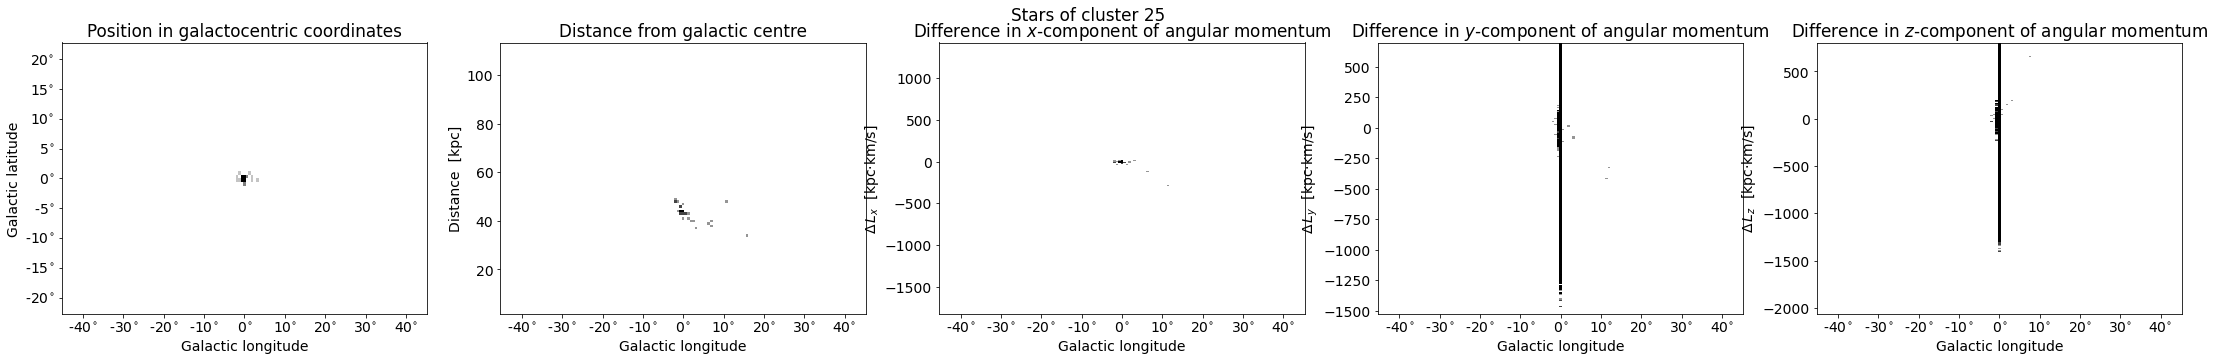

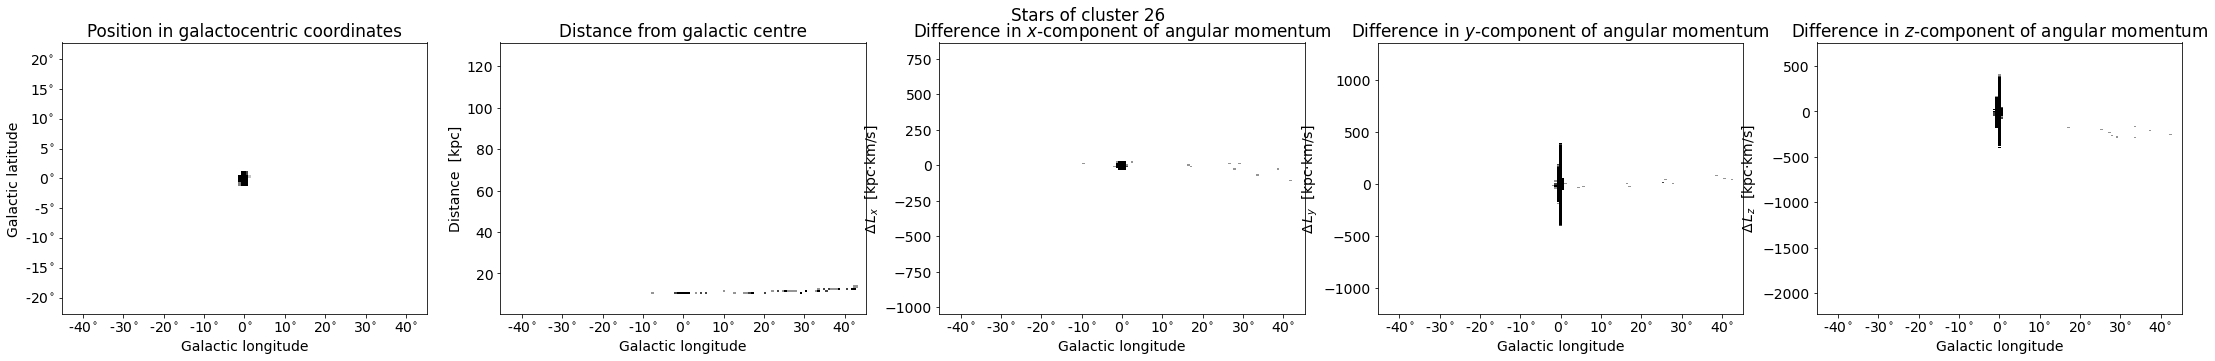

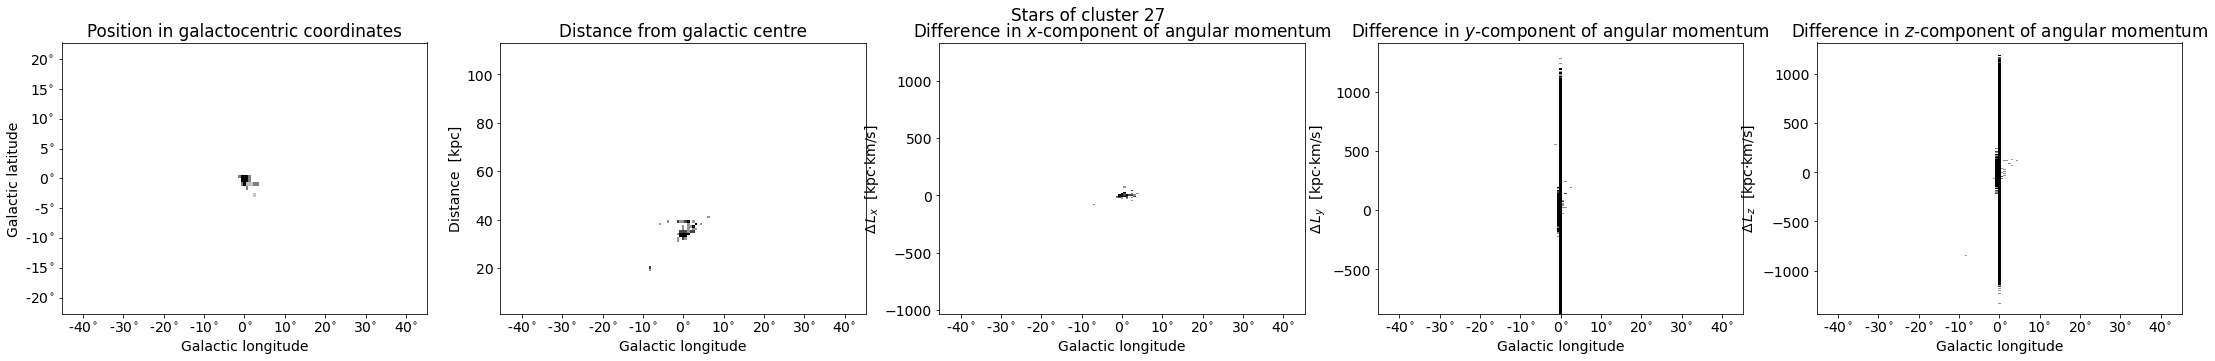

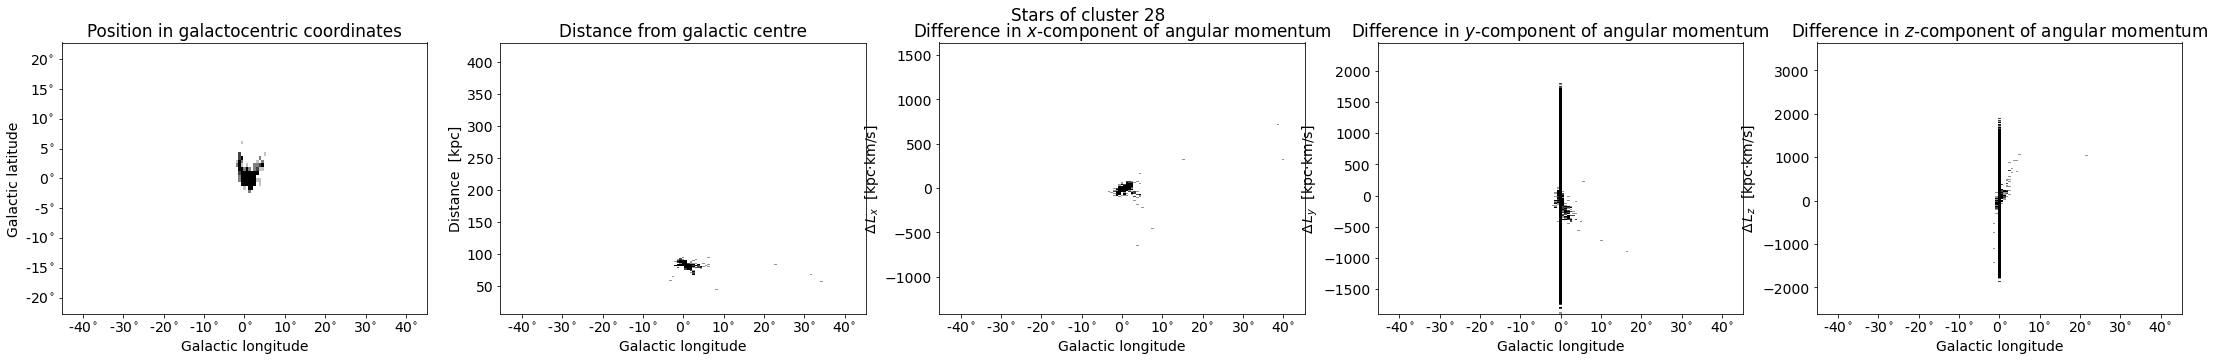

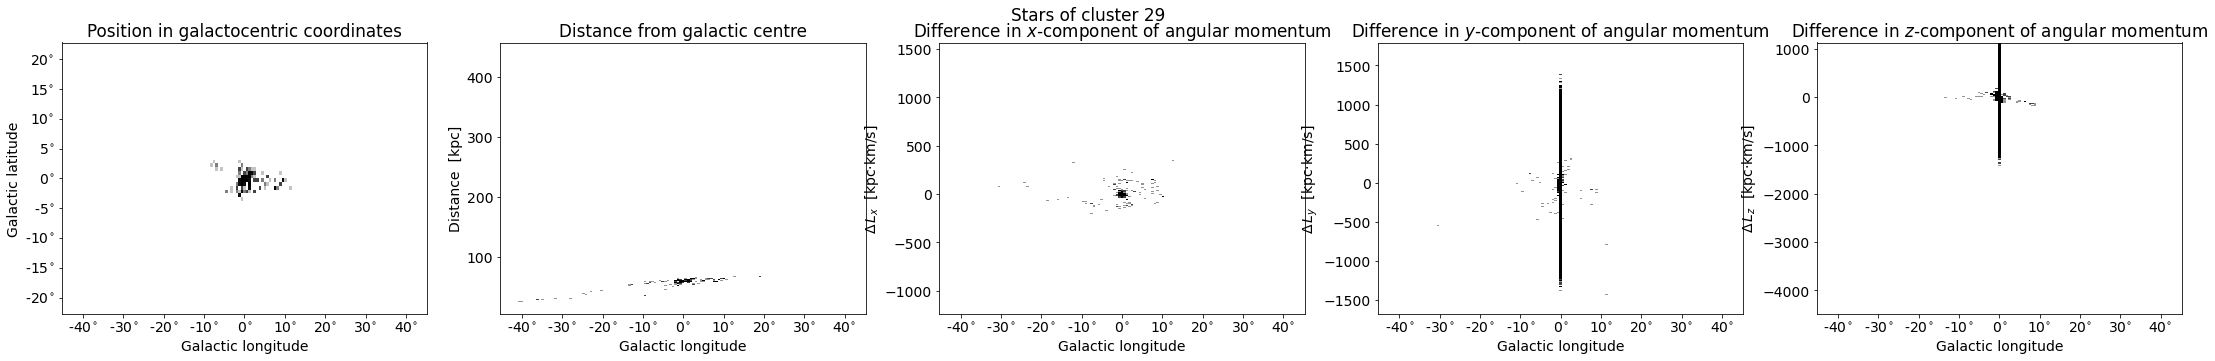

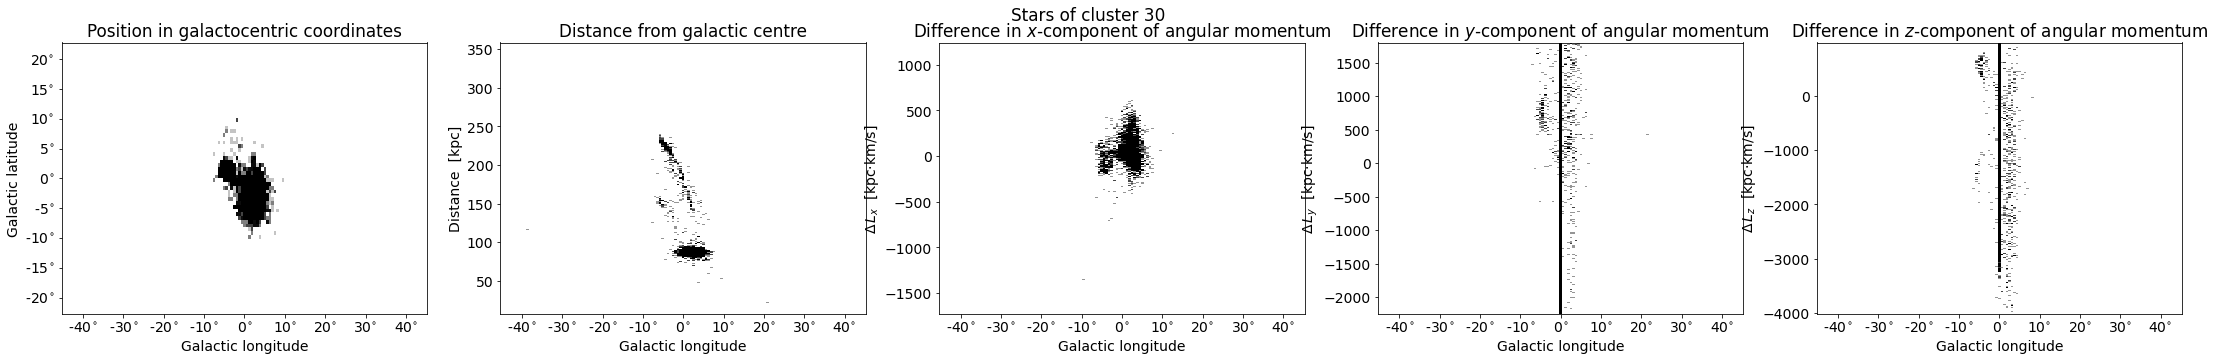

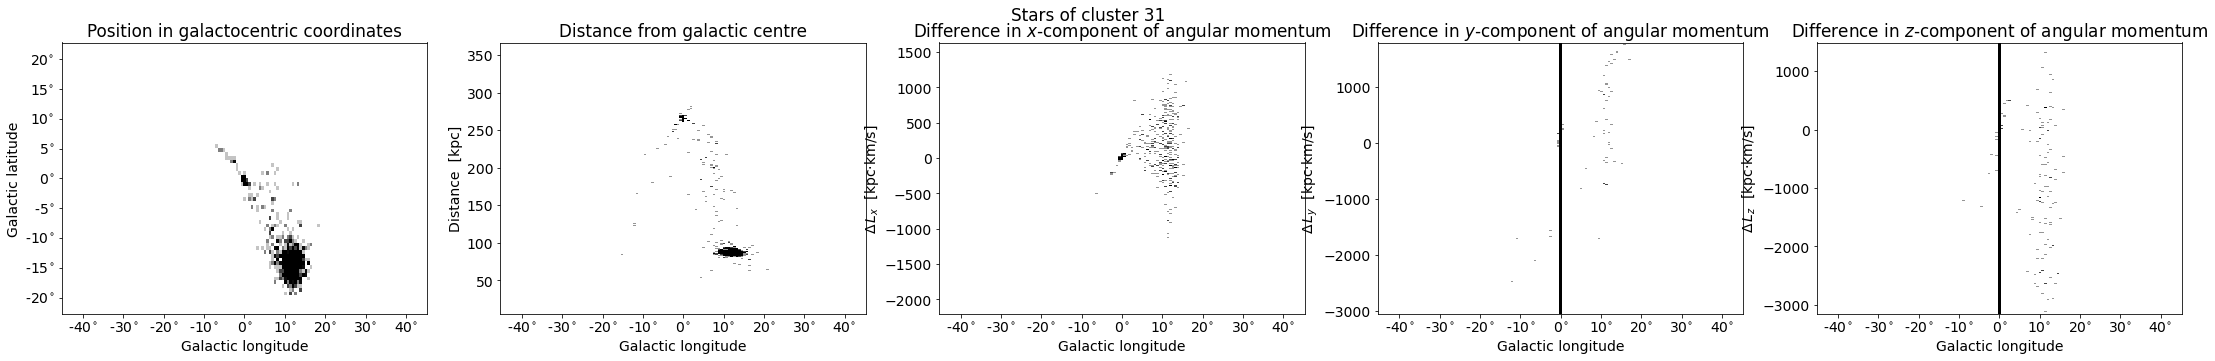

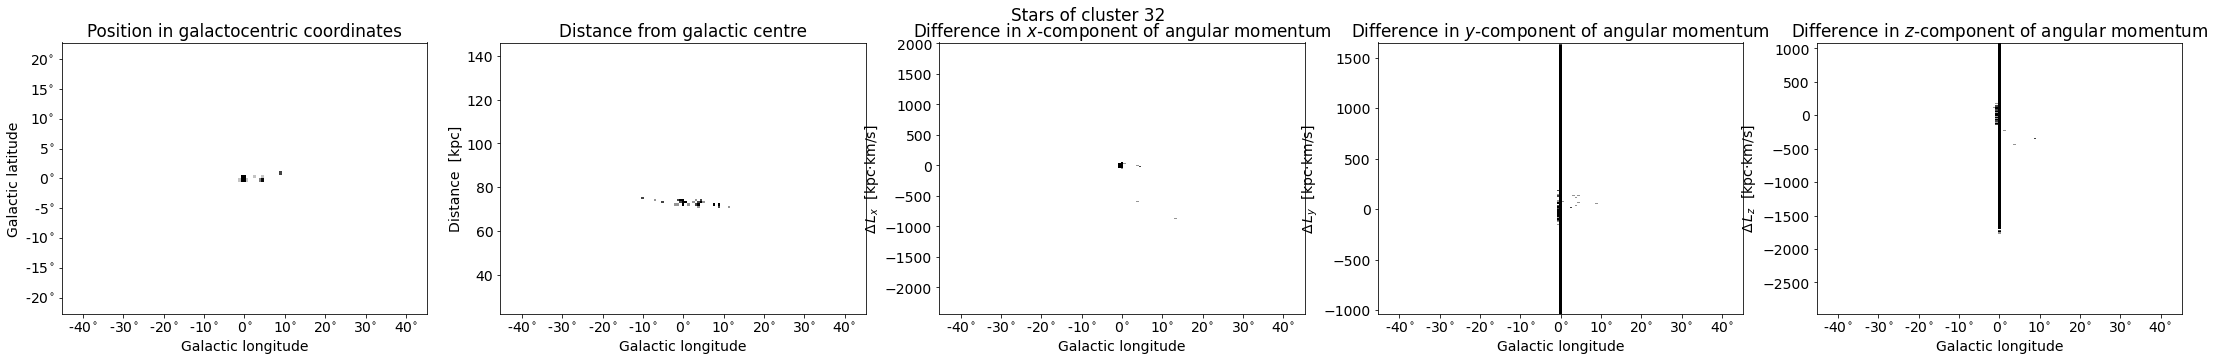

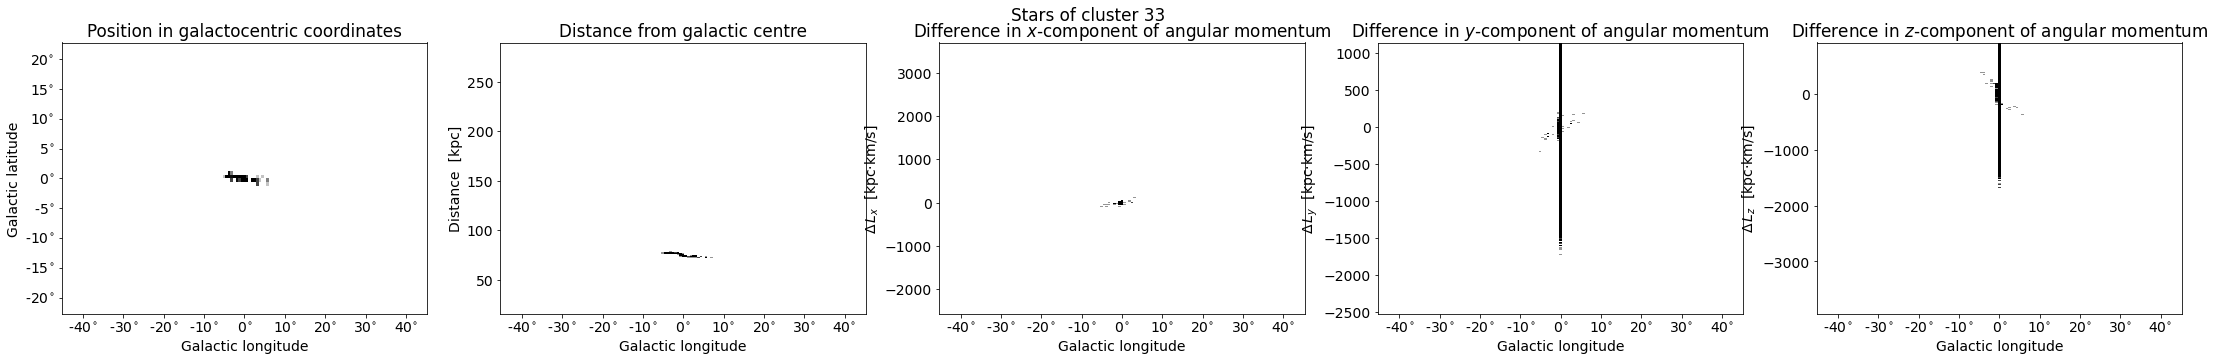

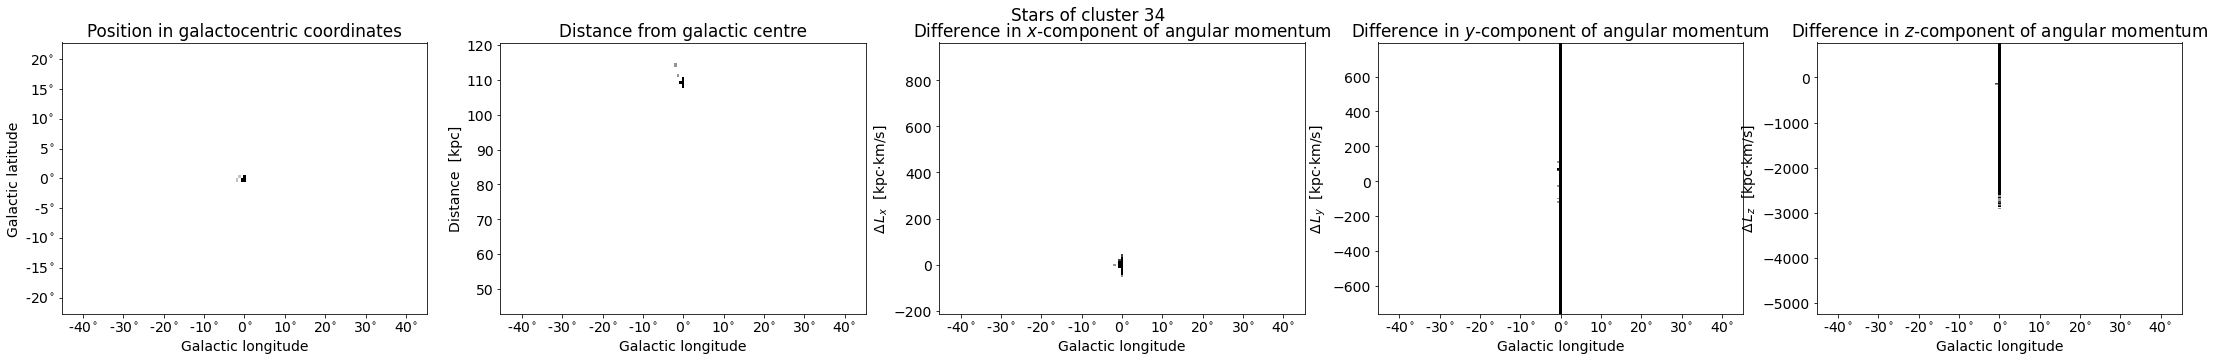

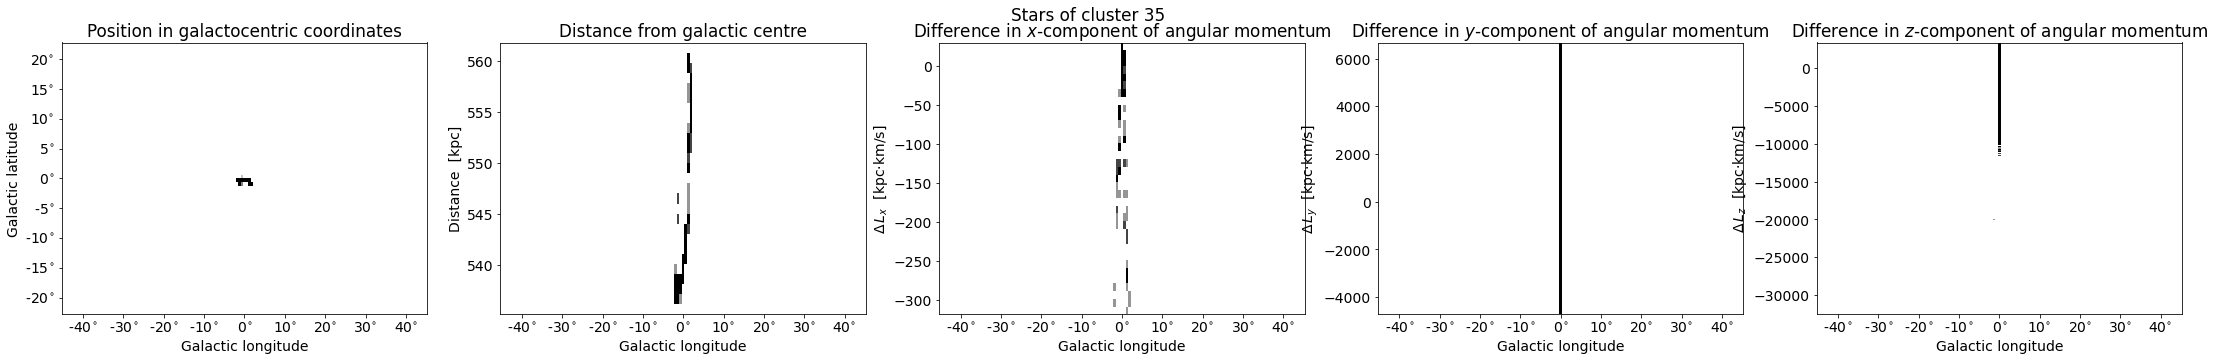

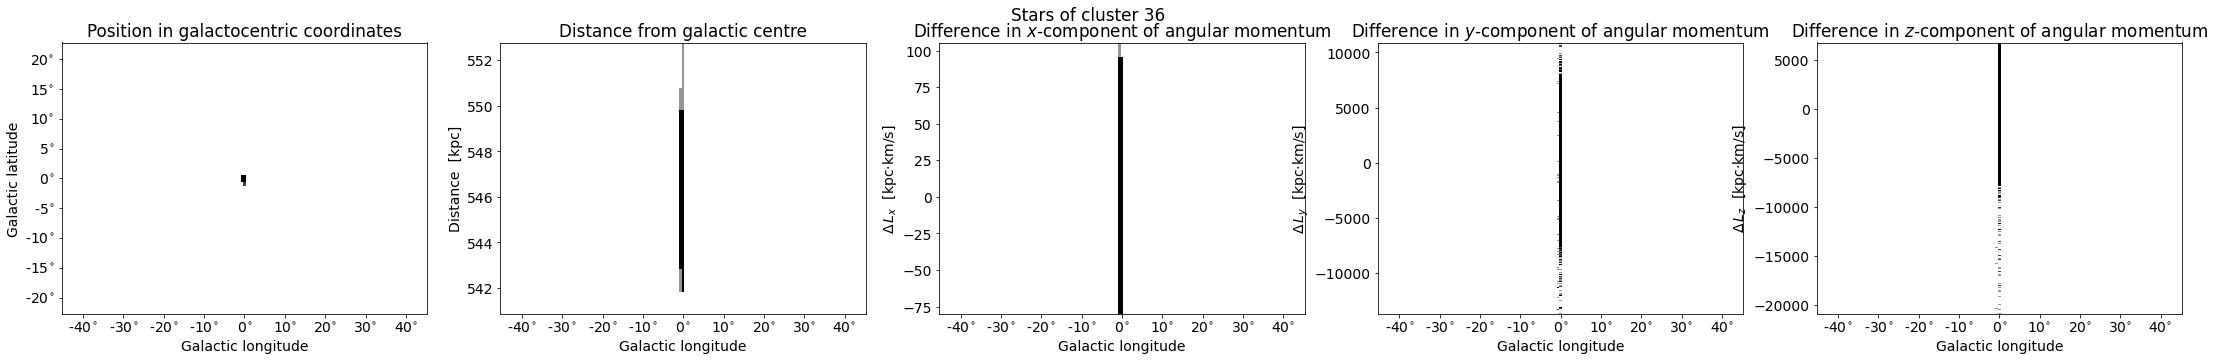

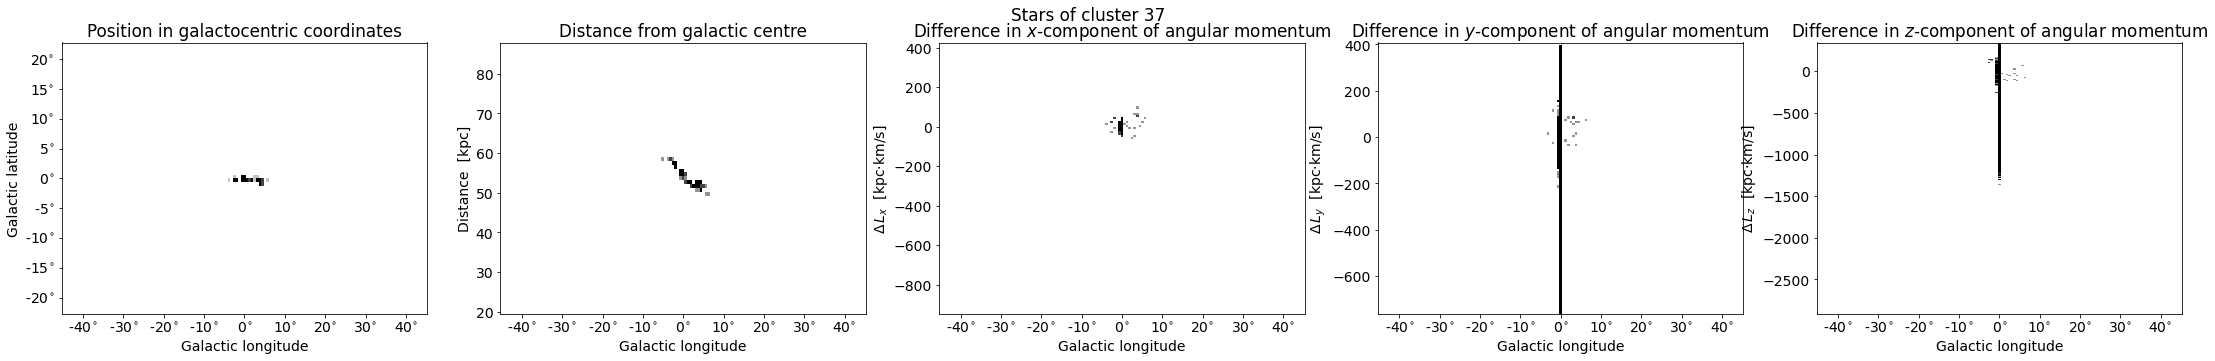

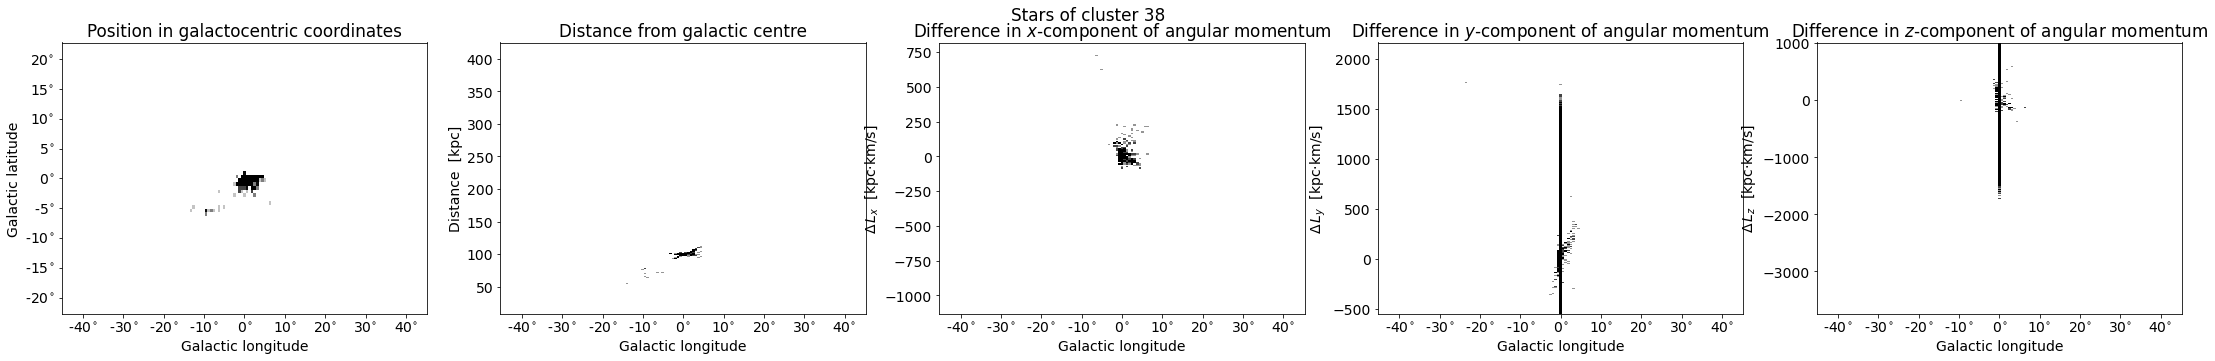

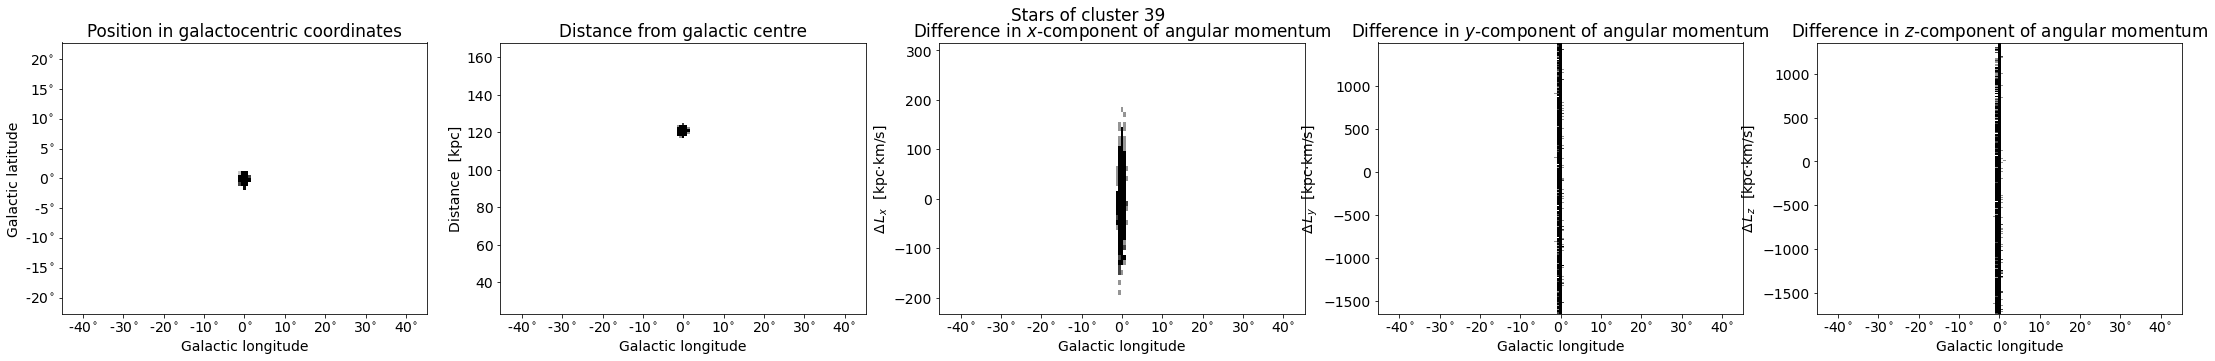

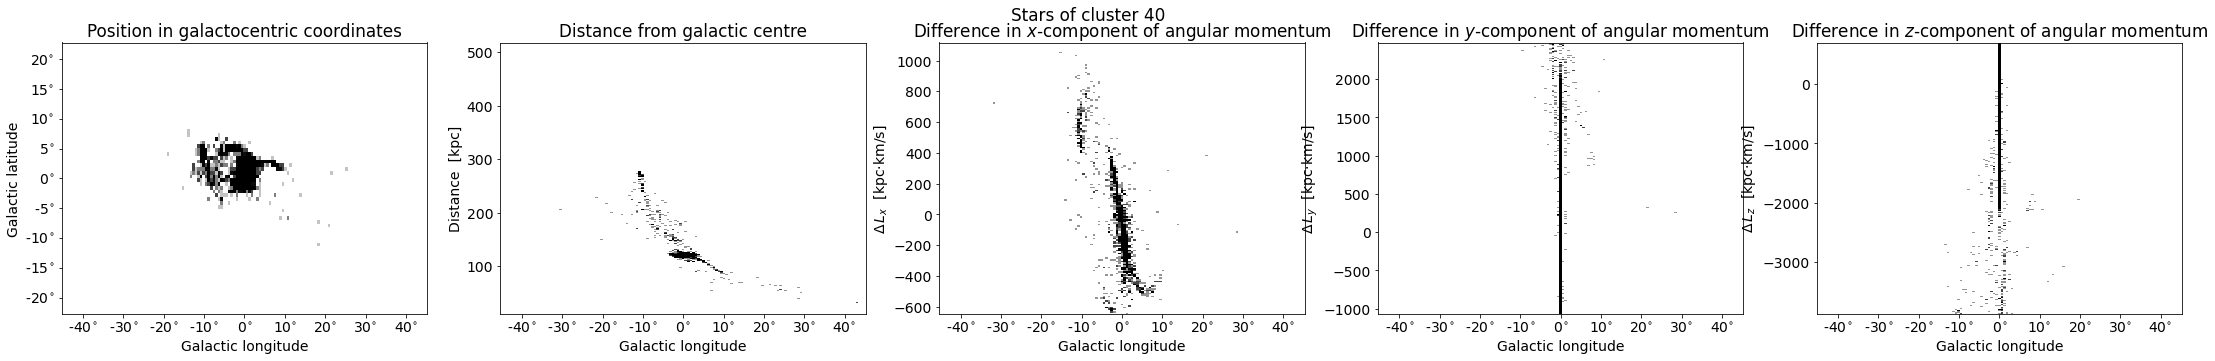

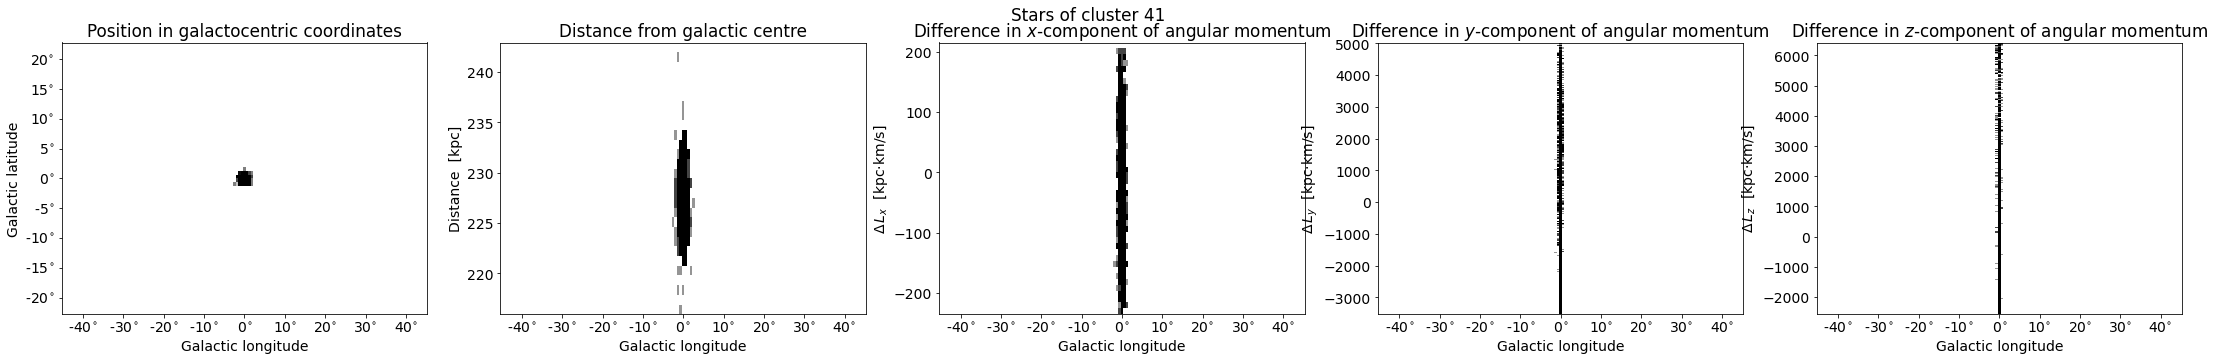

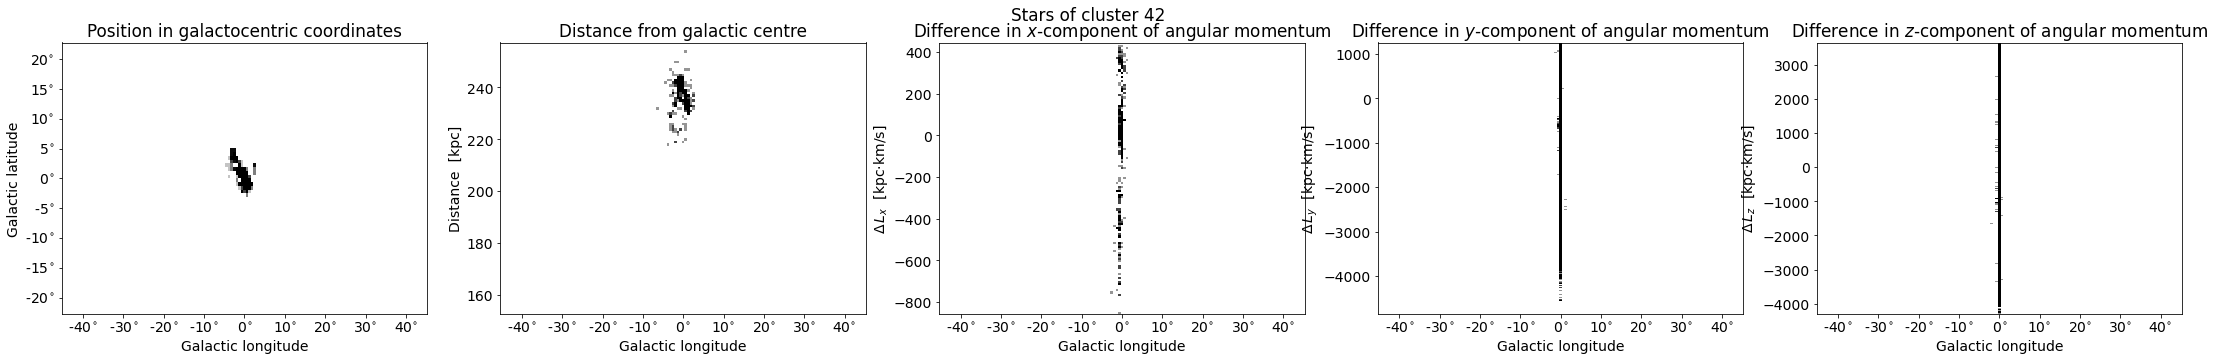

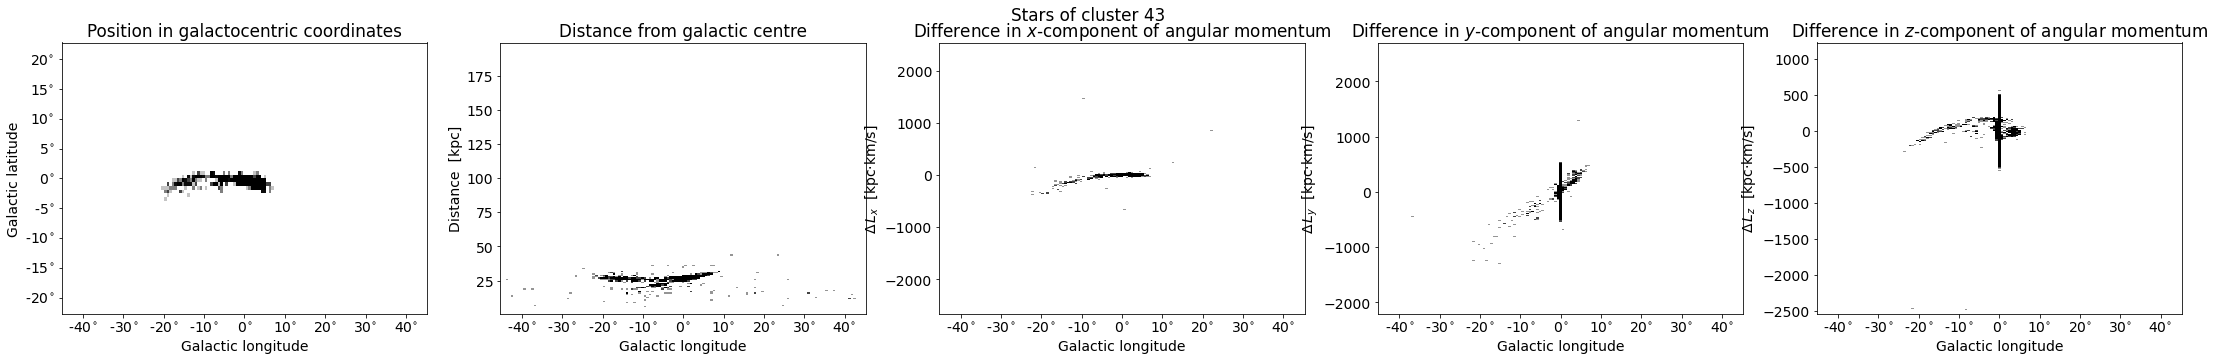

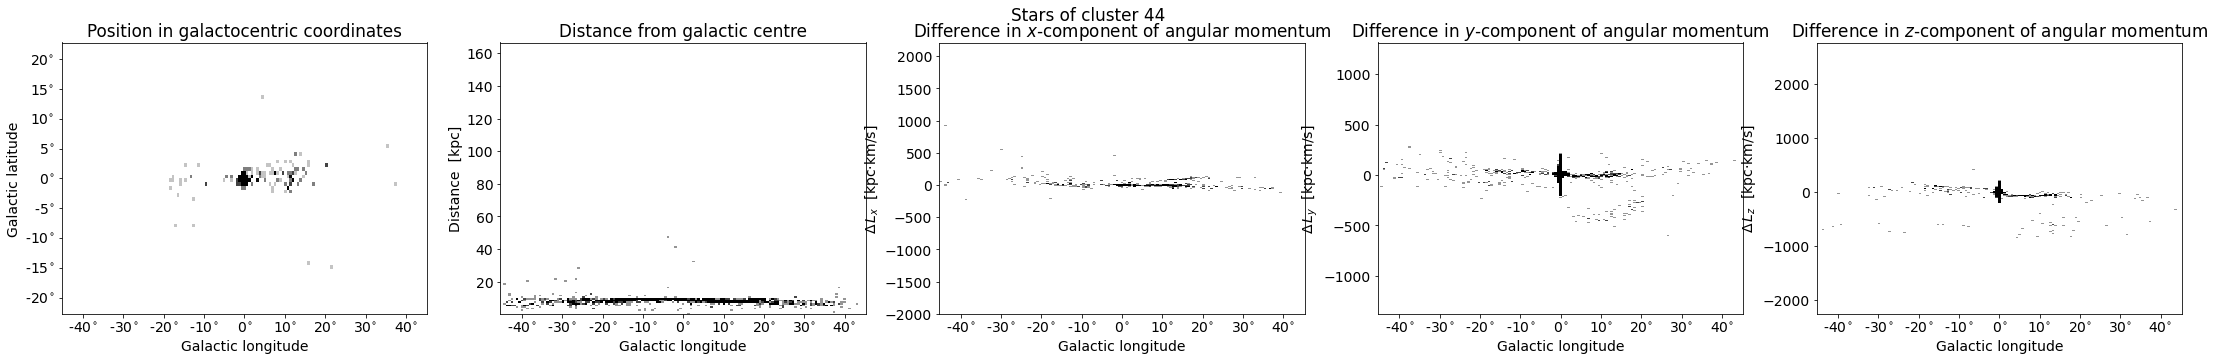

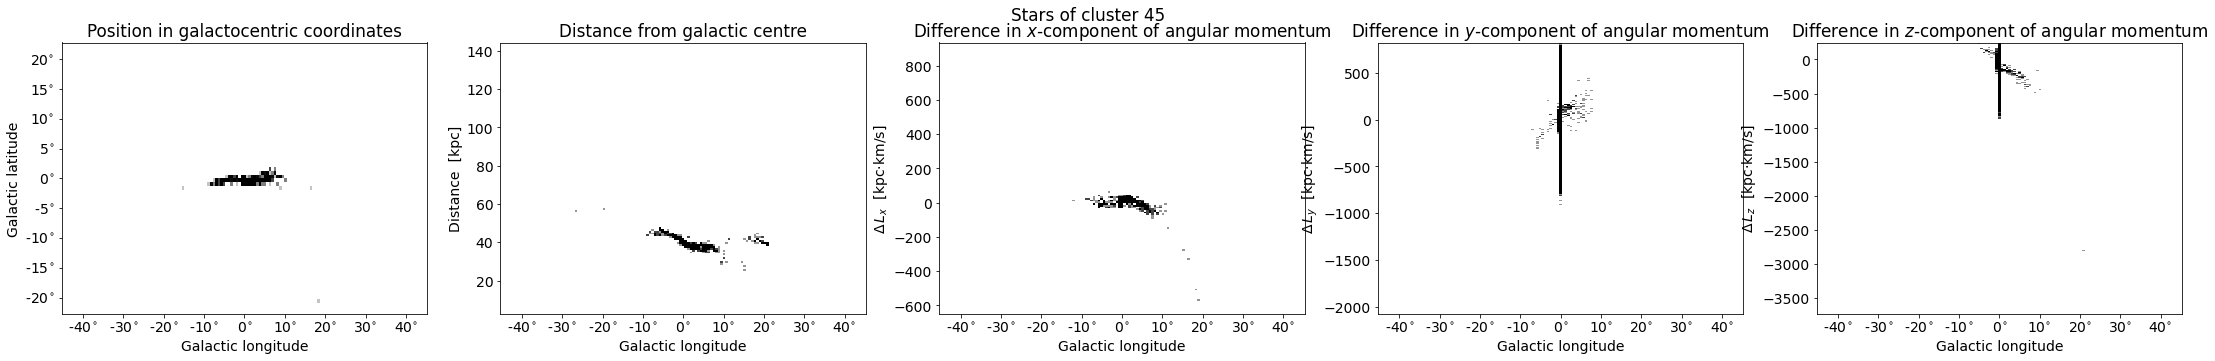

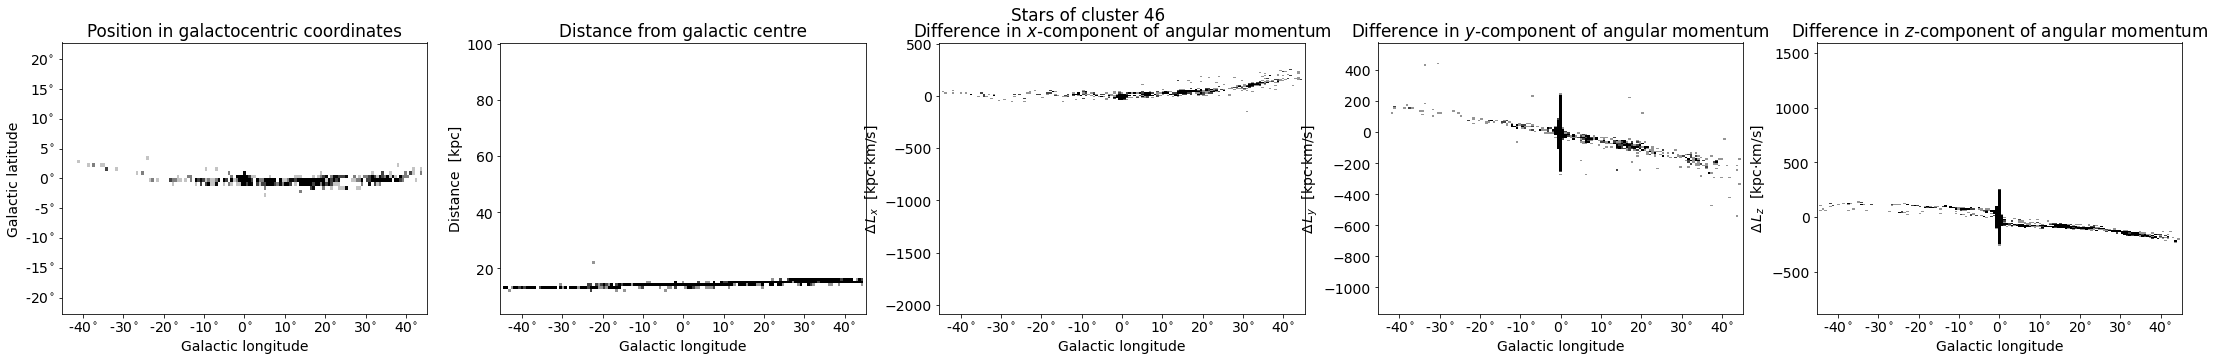

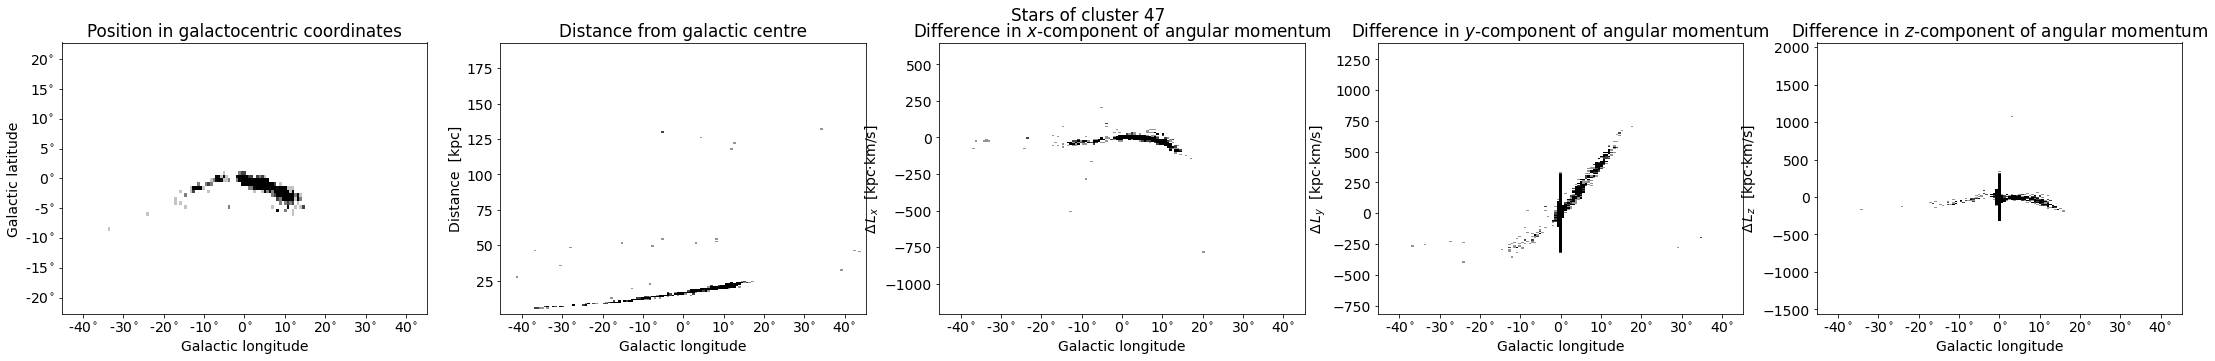

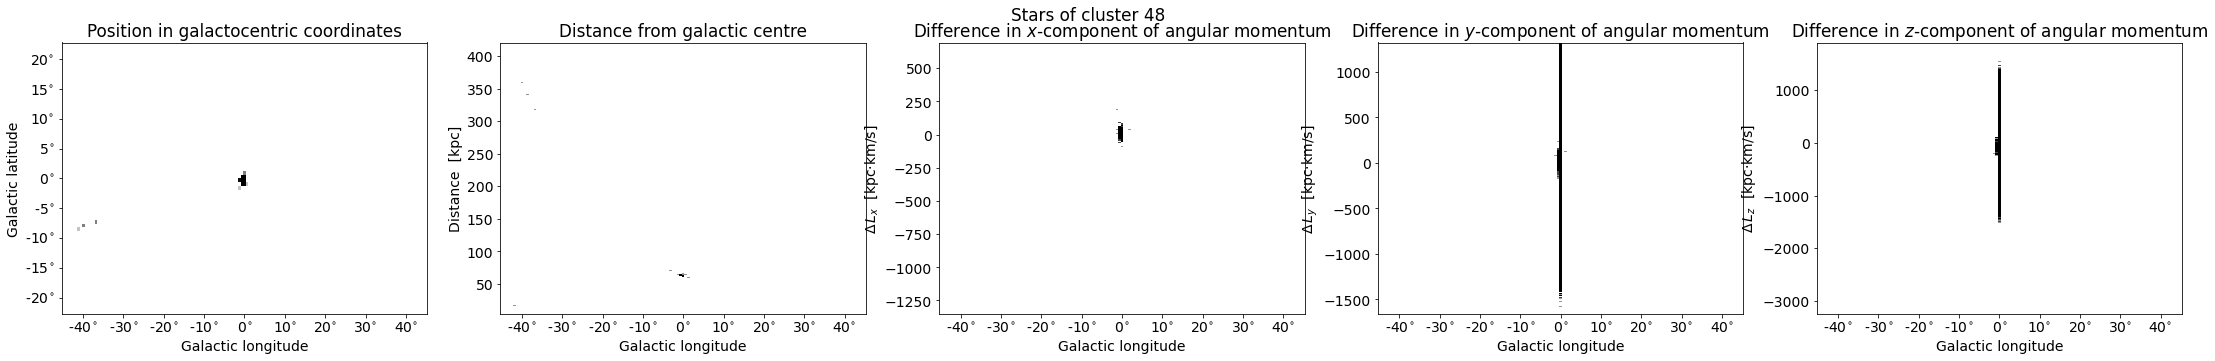

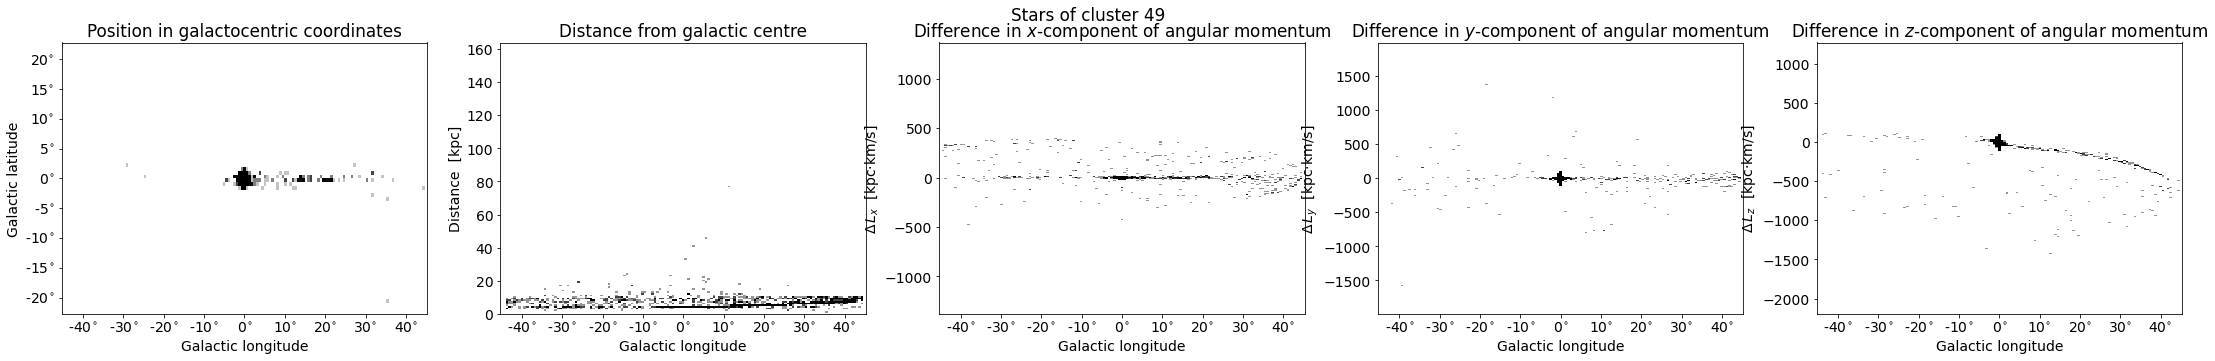

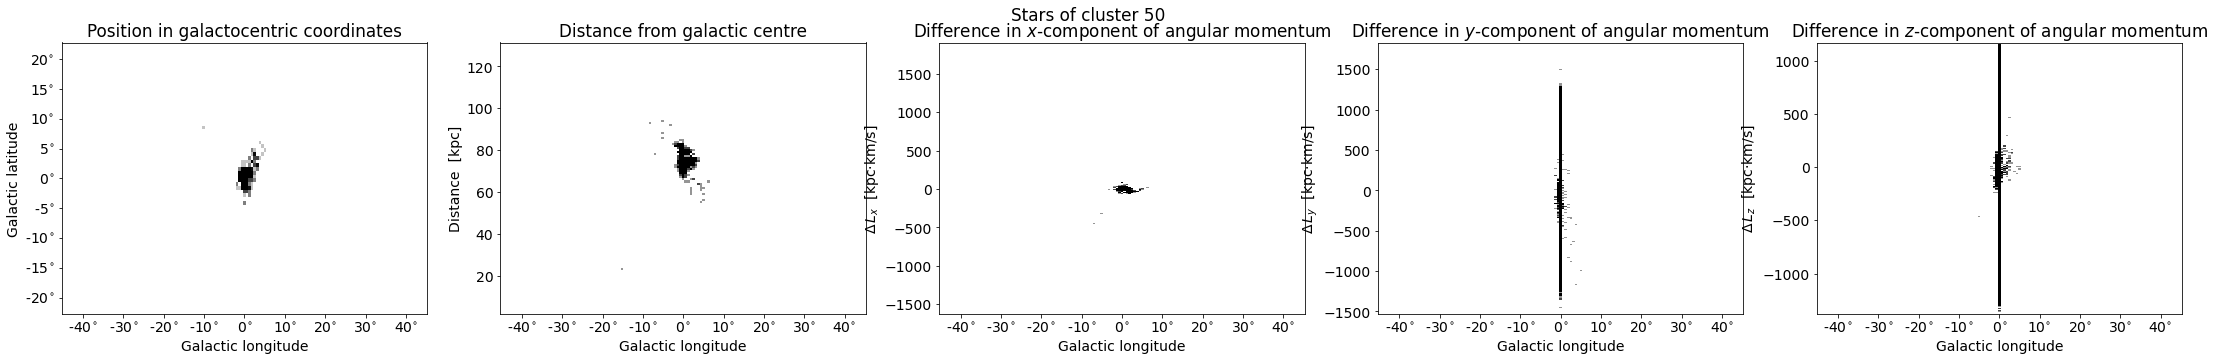

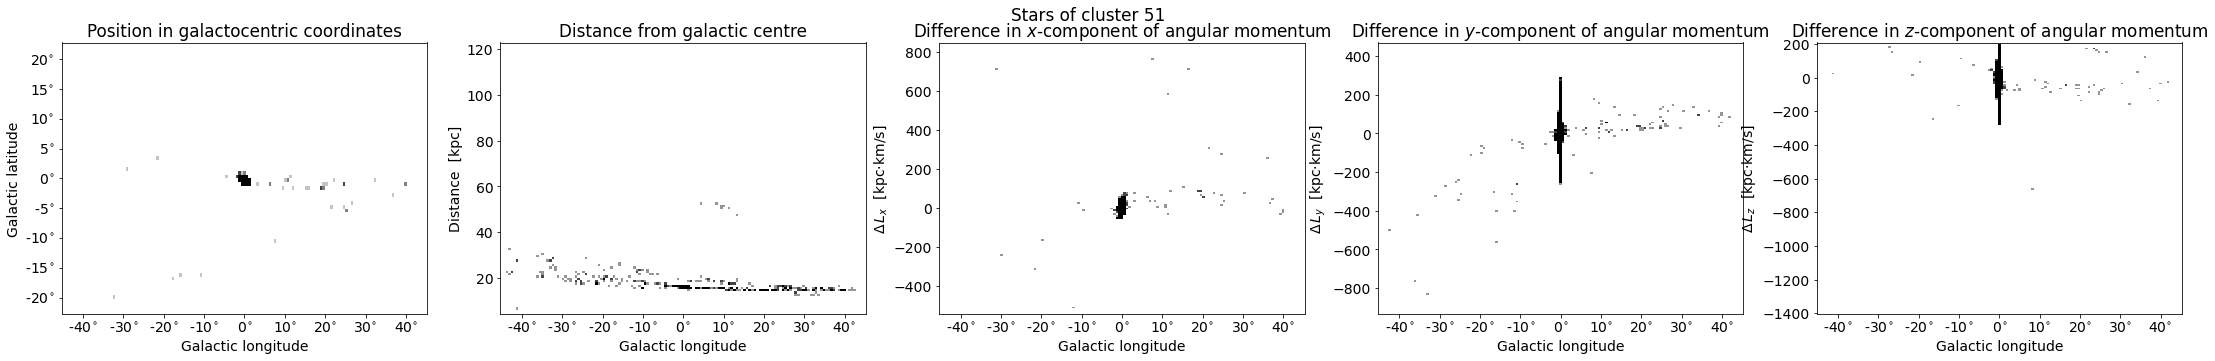

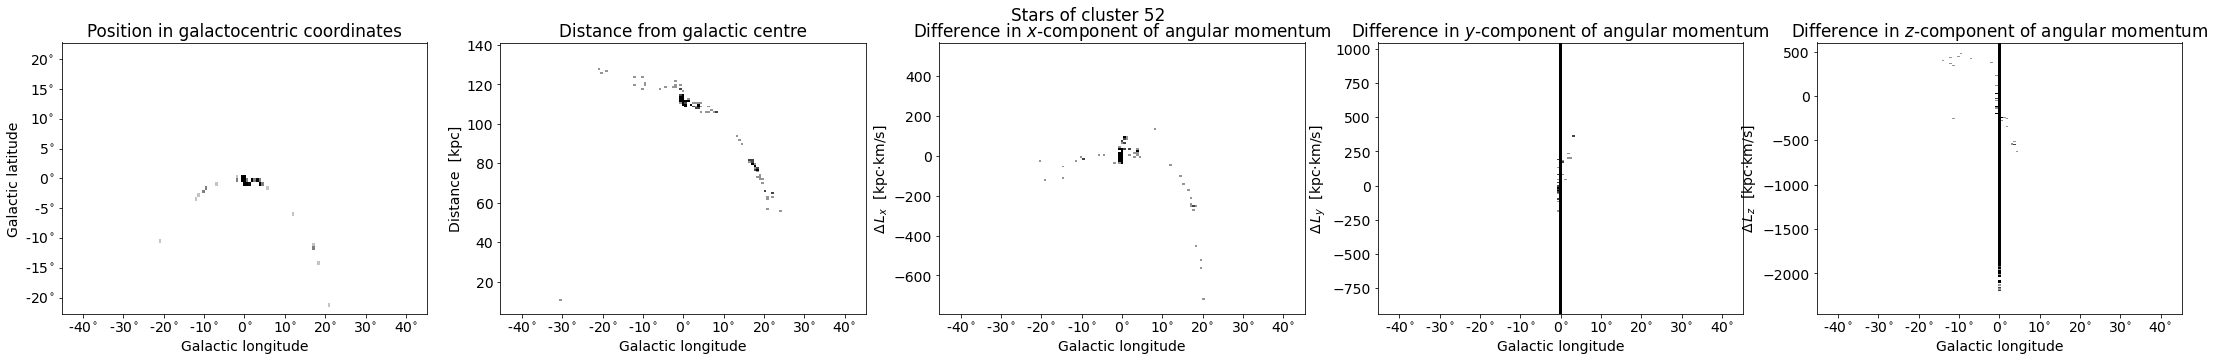

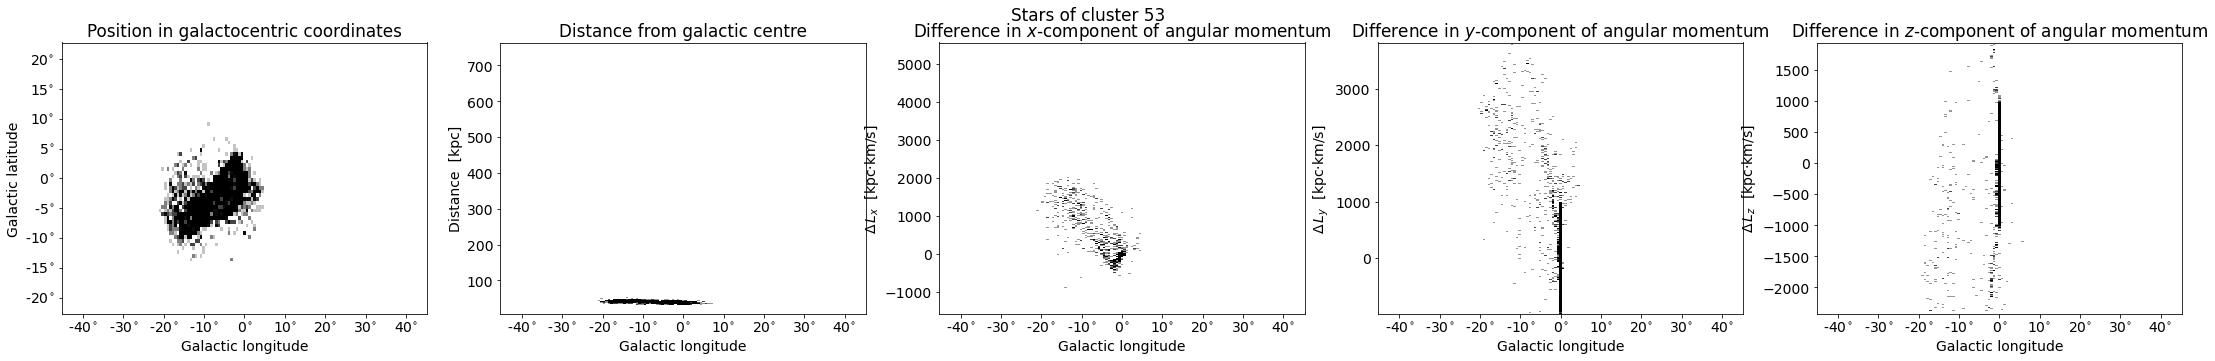

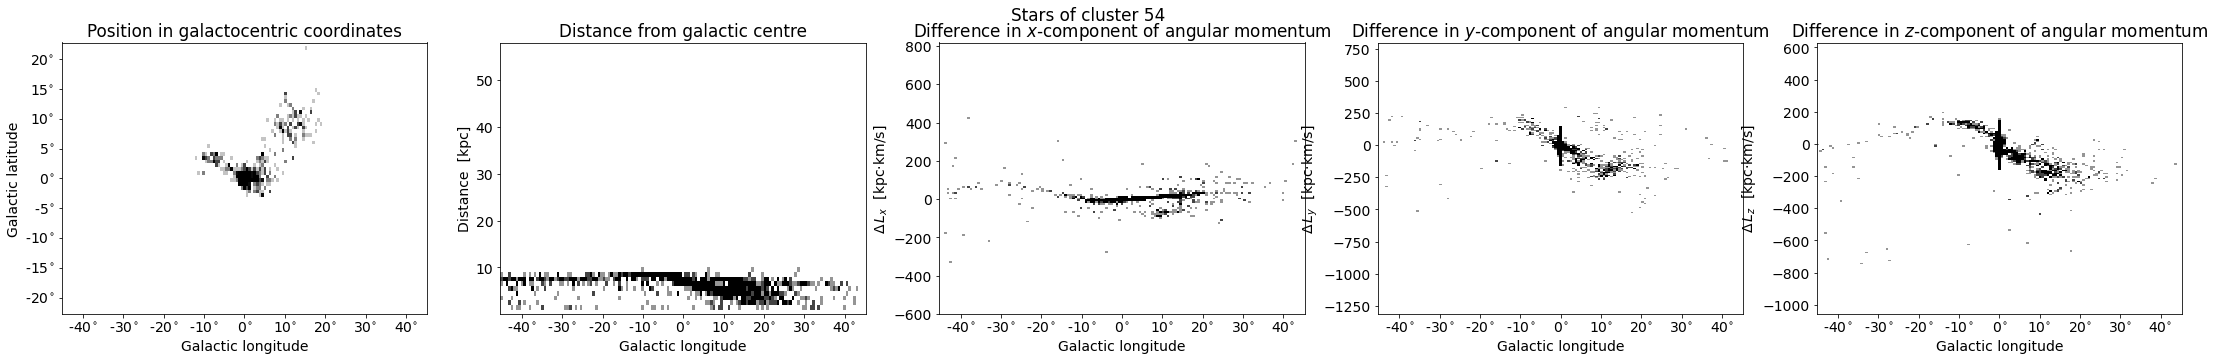

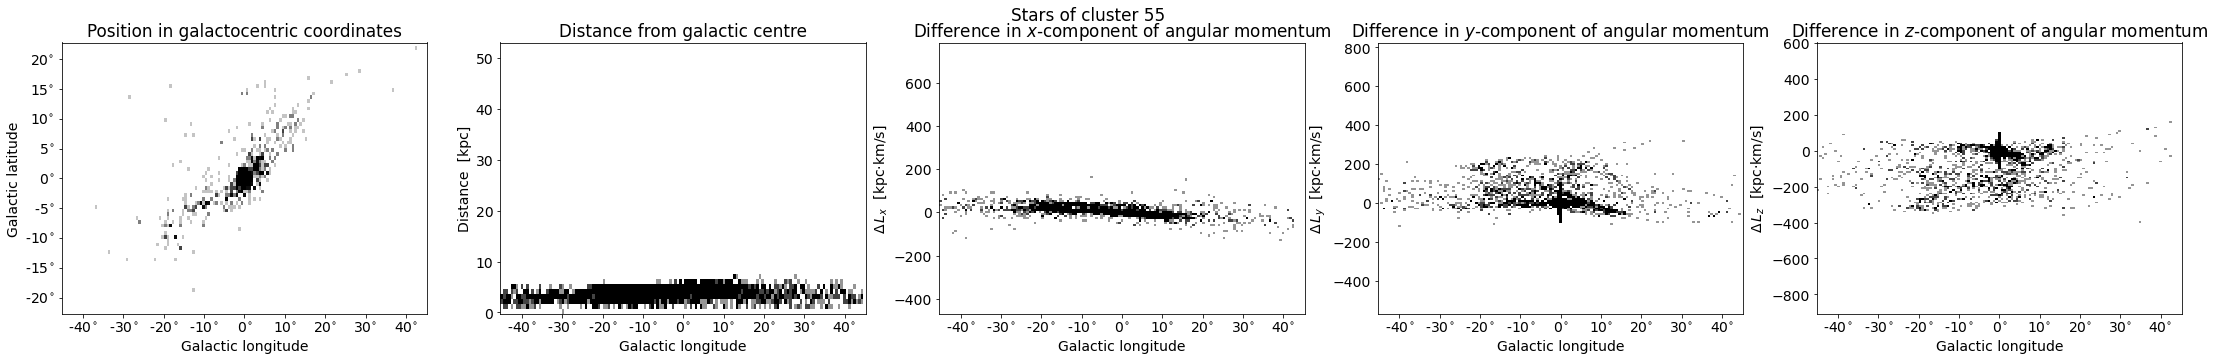

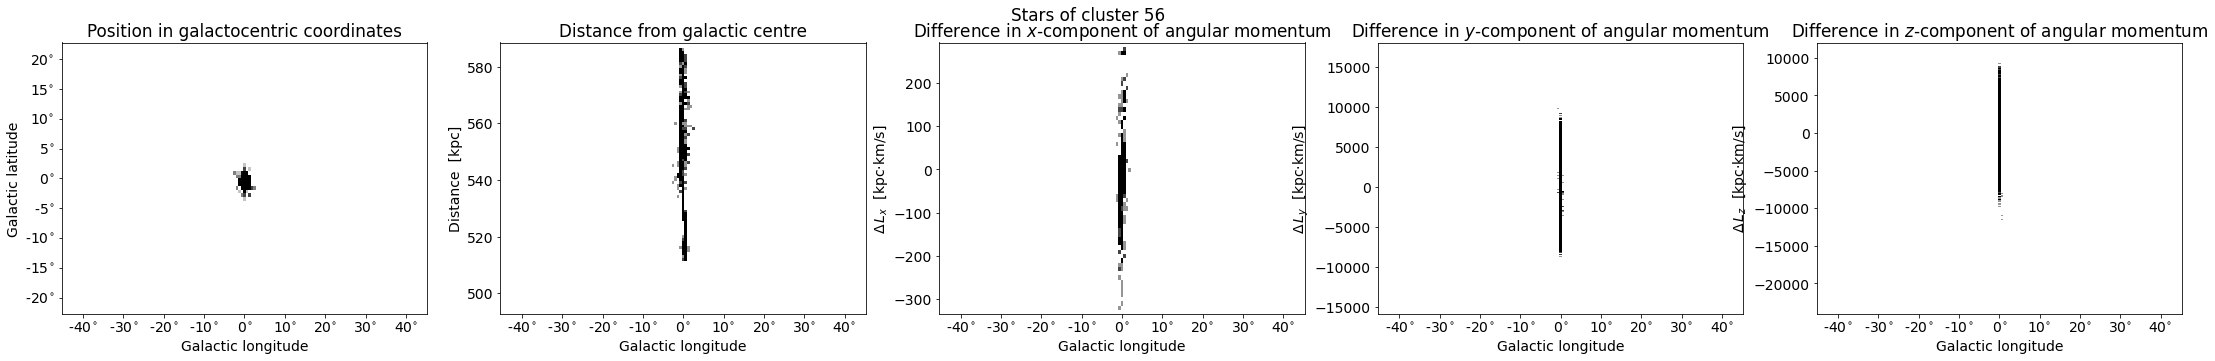

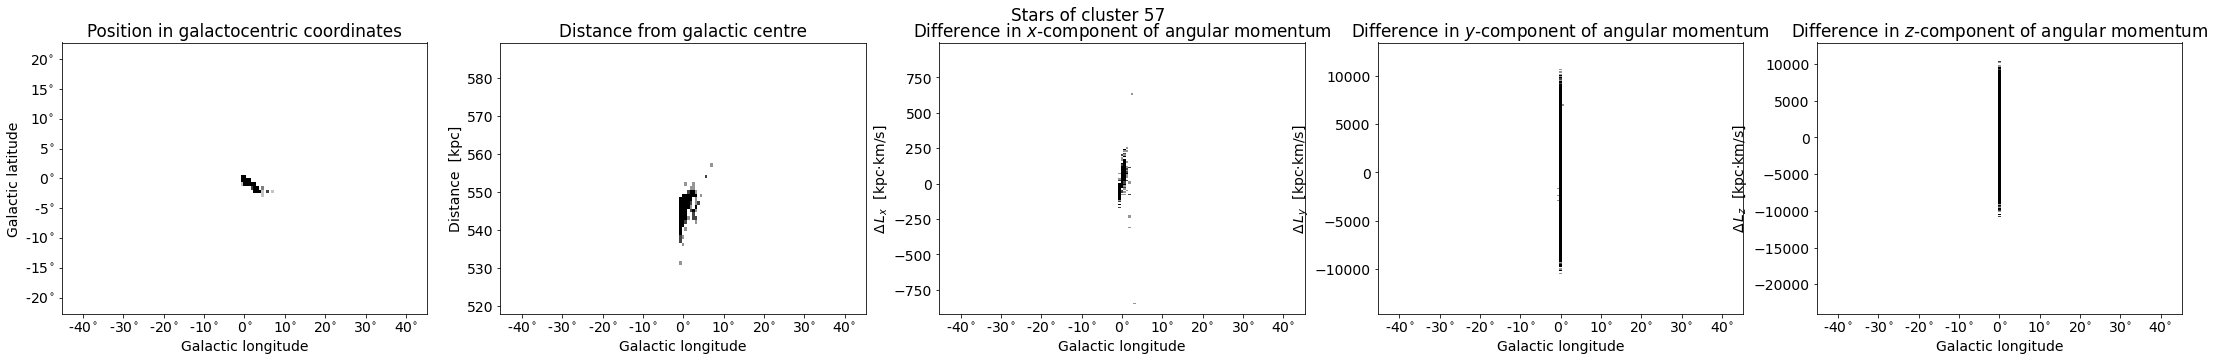

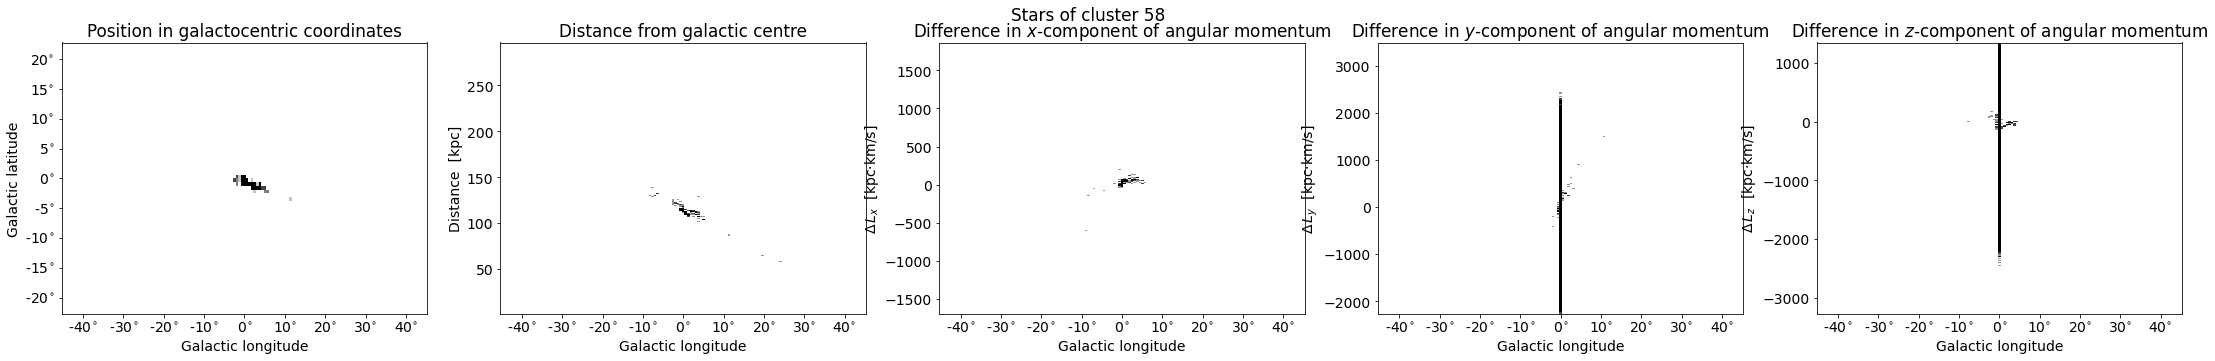

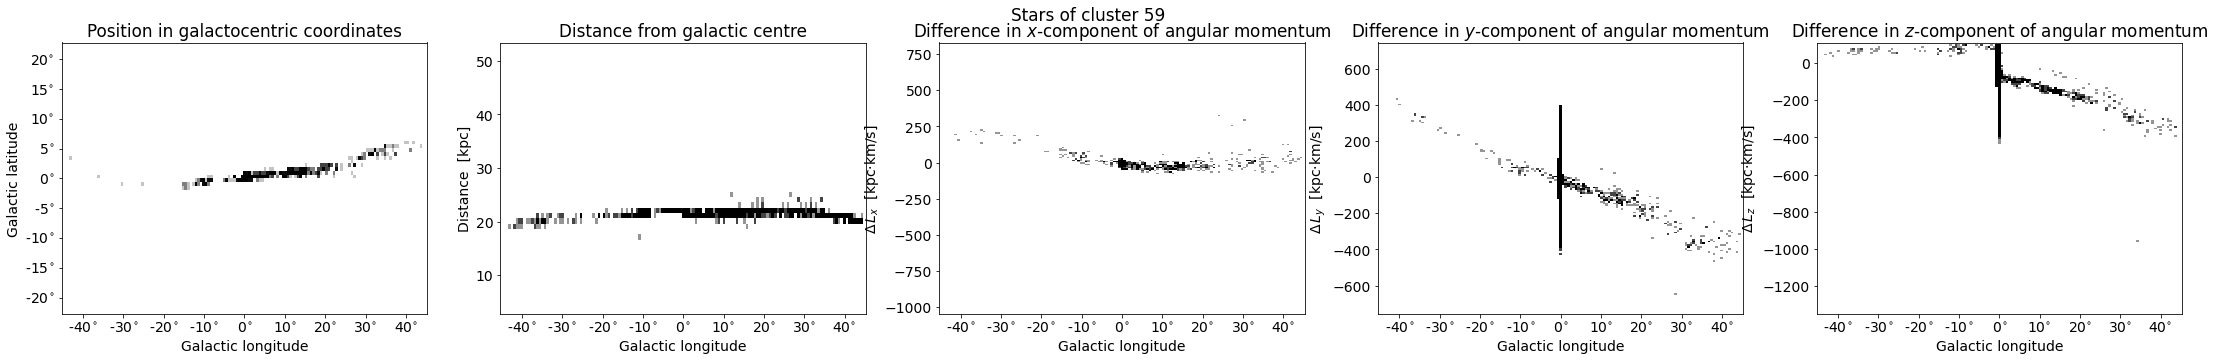

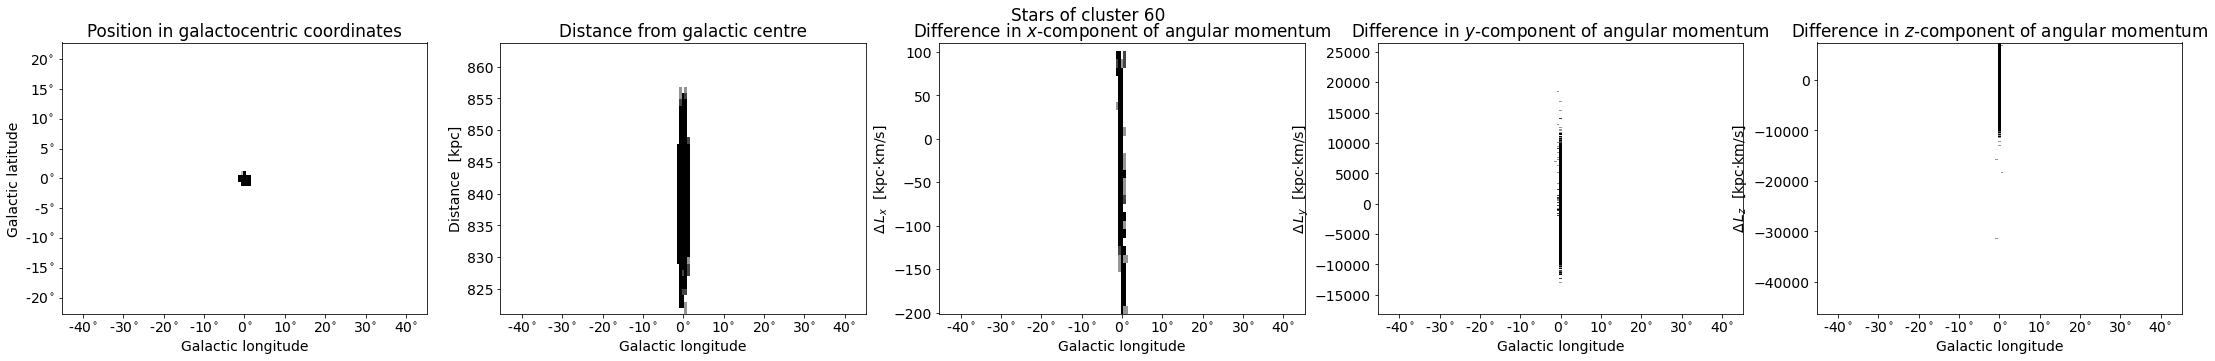

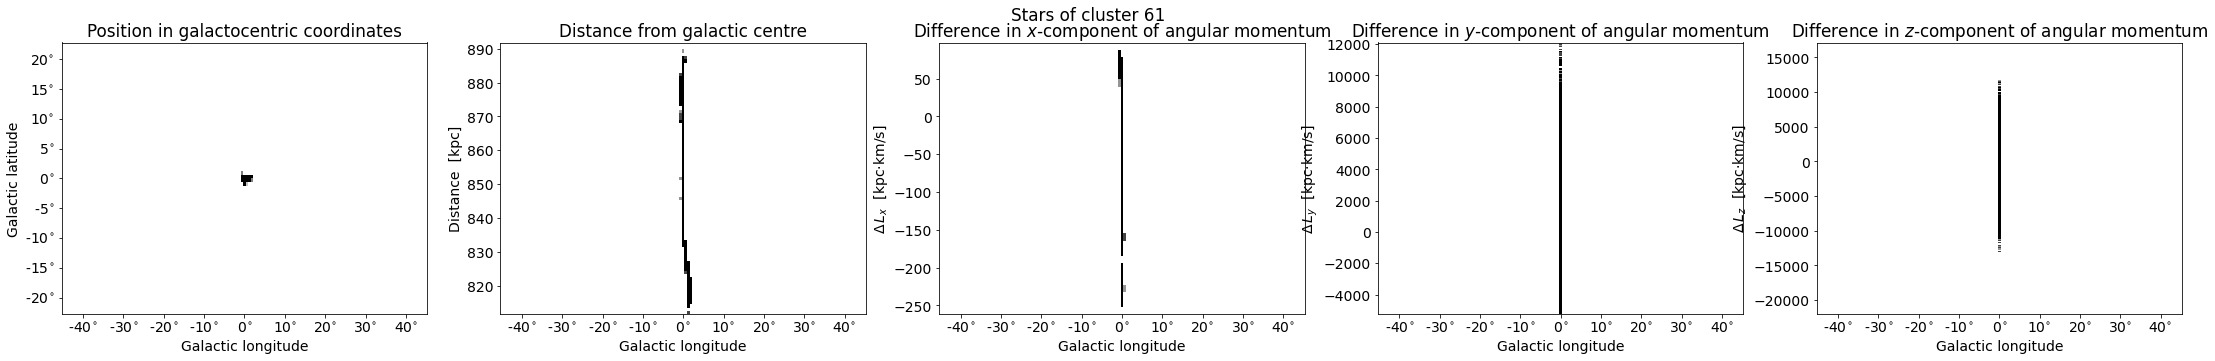

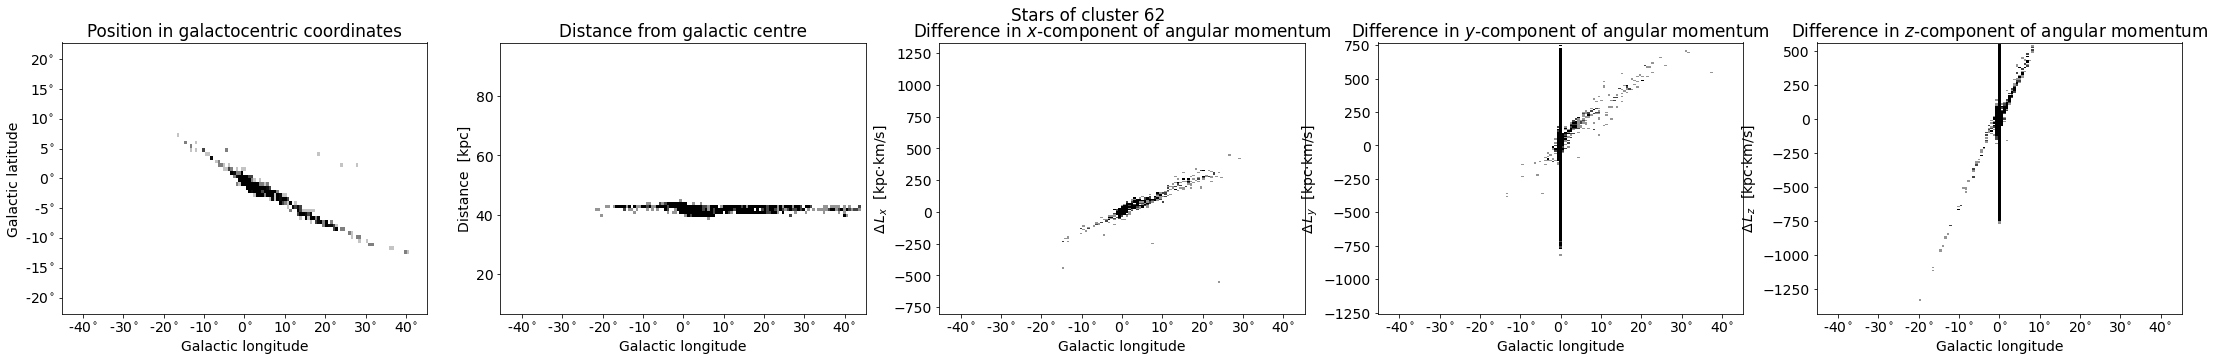

In [ ]:
for cluster in range(nc):
    
    select = (ics == cluster)
    
    cluster_x = xc[cluster]
    cluster_y = yc[cluster]
    cluster_z = zc[cluster]
    cluster_r = np.array([cluster_x, cluster_y, cluster_z])

    cluster_vx = vxc[cluster]
    cluster_vy = vyc[cluster]
    cluster_vz = vzc[cluster]
    cluster_v = np.array([cluster_vx, cluster_vy, cluster_vz])

    cluster_L = np.cross(cluster_r, cluster_v)
    
    transform = build_triple_rotation_matrix(ref_r=cluster_r, ref_L=cluster_L)

    new_cluster_r = transform @ cluster_r
    new_cluster_L = transform @ cluster_L
    
    new_cluster_Lx = new_cluster_L[0]
    new_cluster_Ly = new_cluster_L[1]
    new_cluster_Lz = new_cluster_L[2]

    ####
    stars_d = ds[select]
    ####
    
    stars_x = xs[select]
    stars_y = ys[select]
    stars_z = zs[select]

    stars_vx = vxs[select]
    stars_vy = vys[select]
    stars_vz = vzs[select]

    new_stars_Lx = []
    new_stars_Ly = []
    new_stars_Lz = []
    
    new_stars_x = []
    new_stars_y = []
    new_stars_z = []

    for i in range(len(stars_x)):

        star_x = stars_x[i]
        star_y = stars_y[i]
        star_z = stars_z[i]
        star_r = [star_x, star_y, star_z]

        star_vx = stars_vx[i]
        star_vy = stars_vy[i]
        star_vz = stars_vz[i]
        star_v = [star_vx, star_vy, star_vz]

        star_L = np.cross(star_r, star_v)
        new_star_L = transform @ star_L

        new_stars_Lx.append(new_star_L[0])
        new_stars_Ly.append(new_star_L[1])
        new_stars_Lz.append(new_star_L[2])

        new_star_r = transform @ star_r

        new_stars_x.append(new_star_r[0])
        new_stars_y.append(new_star_r[1])
        new_stars_z.append(new_star_r[2])

    new_stars_Lx = np.array(new_stars_Lx)
    new_stars_Ly = np.array(new_stars_Ly)
    new_stars_Lz = np.array(new_stars_Lz)

    new_stars_x = np.array(new_stars_x)
    new_stars_y = np.array(new_stars_y)
    new_stars_z = np.array(new_stars_z)
    
    new_stars_delta_Lx = new_stars_Lx - new_cluster_Lx
    new_stars_delta_Ly = new_stars_Ly - new_cluster_Ly
    new_stars_delta_Lz = new_stars_Lz - new_cluster_Lz

    new_stars_L_perp = np.sqrt((new_stars_delta_Lx) ** 2 + (new_stars_delta_Ly) ** 2)

    new_stars_rho = np.sqrt(new_stars_x ** 2 + new_stars_y ** 2 + new_stars_z ** 2)
    
    # longs and lats formulae taken from previous notebook
    stars_longitudes = np.arctan2(new_stars_y, new_stars_x)
    stars_latitudes = np.arcsin(new_stars_z / new_stars_rho)
    
    
    plt.figure(figsize=(38, 5))
    plt.rc('font', size=14)
    

    lon_v, lat_v = np.meshgrid(lon, lat)

    D = np.zeros((ng_lat + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) and (-lat_max <= stars_latitudes[star] <= lat_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((stars_latitudes[star] + lat_max) / dg)) 
            D[iy, ix] += 1

    Ds = np.sqrt(D)

    plt.subplot(1,5,1)
    plt.pcolormesh(lon_v, lat_v, Ds, cmap='binary', vmin=1.5, vmax=2.5)

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)
    plt.yticks(ticks=lat_range_deg * u.deg.to(u.rad), labels=lat_range_deg_str)

    plt.xlabel('Galactic longitude')
    plt.ylabel('Galactic latitude')
    plt.title('Position in galactocentric coordinates')


    ###
    d_max = max(stars_d) #/ zoom
    d_min = min(stars_d) #/ zoom
    ng_d = int((d_max - d_min) * 1 + 1)

    d_linspace = np.linspace(d_min, d_max, ng_d + 1) 
    lon_v, d_v = np.meshgrid(lon, d_linspace)

    D = np.zeros((ng_d + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) \
    and (d_min <= stars_d[star] <= d_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((stars_d[star] + -d_min) * 1)) 

            D[iy, ix] += 1

    Ds = np.sqrt(D)
    ###

    plt.subplot(1,5,2)
    plt.pcolormesh(lon_v, d_v, Ds, cmap='binary', vmin=1, vmax=2)

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

    plt.xlabel('Galactic longitude')
    plt.ylabel('Distance  [kpc]')
    plt.title('Distance from galactic centre')


    ###
    L_x_max = max(new_stars_delta_Lx) / zoom
    L_x_min = min(new_stars_delta_Lx) / zoom
    ng_L_x = int((L_x_max - L_x_min) / 10 + 1)

    L_x_linspace = np.linspace(L_x_min, L_x_max, ng_L_x + 1) 
    lon_v, L_x_v = np.meshgrid(lon, L_x_linspace)

    D = np.zeros((ng_L_x + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) \
    and (L_x_min <= new_stars_delta_Lx[star] <= L_x_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((new_stars_delta_Lx[star] + -L_x_min) / 10)) 

            D[iy, ix] += 1

    Ds = np.sqrt(D)
    ###

    plt.subplot(1,5,3)
    plt.pcolormesh(lon_v, L_x_v, Ds, cmap='binary', vmin=1, vmax=2)

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

    plt.xlabel('Galactic longitude')
    plt.ylabel(r'$\Delta \, L_x$  [kpc$\cdot$km/s]')
    plt.title(r'Difference in $x$-component of angular momentum')


    ###
    L_y_max = max(new_stars_delta_Ly) / zoom
    L_y_min = min(new_stars_delta_Ly) / zoom
    ng_L_y = int((L_y_max - L_y_min) / 10 + 1)

    L_y_linspace = np.linspace(L_y_min, L_y_max, ng_L_y + 1) 
    lon_v, L_y_v = np.meshgrid(lon, L_y_linspace)

    D = np.zeros((ng_L_y + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) and (L_y_min <= new_stars_delta_Ly[star] <= L_y_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((new_stars_delta_Ly[star] + -L_y_min) / 10)) 

            D[iy, ix] += 1

    Ds = np.sqrt(D)
    ###    

    plt.subplot(1,5,4)
    plt.pcolormesh(lon_v, L_y_v, Ds, cmap='binary', vmin=1, vmax=2)

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

    plt.xlabel('Galactic longitude')
    plt.ylabel(r'$\Delta \, L_y$  [kpc$\cdot$km/s]')
    plt.title(r'Difference in $y$-component of angular momentum')

    ###
    L_z_max = max(new_stars_delta_Lz) / zoom
    L_z_min = min(new_stars_delta_Lz) / zoom
    ng_L_z = int((L_z_max - L_z_min) / 10 + 1)

    L_z_linspace = np.linspace(L_z_min, L_z_max, ng_L_z + 1) 
    lon_v, L_z_v = np.meshgrid(lon, L_z_linspace)

    D = np.zeros((ng_L_z + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) \
    and (L_z_min <= new_stars_delta_Lz[star] <= L_z_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((new_stars_delta_Lz[star] + -L_z_min) / 10)) 

            D[iy, ix] += 1

    Ds = np.sqrt(D)
    ###

    plt.subplot(1,5,5)
    plt.pcolormesh(lon_v, L_z_v, Ds, cmap='binary', vmin=1, vmax=2)

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

    plt.xlabel('Galactic longitude')
    plt.ylabel(r'$\Delta \, L_z$  [kpc$\cdot$km/s]')
    plt.title(r'Difference in $z$-component of angular momentum')

    
    plt.suptitle('Stars of cluster ' + str(cluster))
    plt.show()